# <center>Final Project</center> #
### Machine Learning for Big Data - CSCI 6515

Bhumi Patel (B00824756)<br>
Aakash Patel (B00807065)
<hr>

### <center>Data Preprocessing</center> ###

In [1]:
import glob
import xml.etree.ElementTree as ET
import pandas as pd
from pprint import pprint
import nltk
from nltk.stem import PorterStemmer
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from pprint import pprint
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import LabelEncoder
import keras
from keras.layers import Input, Dense
from keras.models import Model
from keras.callbacks import TensorBoard
import numpy as np 
import os
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns
import warnings
import matplotlib.pyplot as plt
import matplotlib.image as mpimg 
import matplotlib.pyplot as plt
from keras.models import Model
from keras.layers import Dense, Input
from keras.datasets import mnist
from keras.regularizers import l1
from keras.optimizers import Adam

Using TensorFlow backend.


In [ ]:
# getlist of all files in all folders
def getListofFileFunction():
    
    filelist=[];
    for i in range(10,31):
        filename="199703"+str(i)+"/*.xml";
        files=glob.glob(filename);
        filelist.append(files); 
        
    return filelist
 
fileList=getListofFileFunction(); 

# function to get dataframe from xml files 
def XmlToDataframeFunction(fileList,dfColumnList):
    

    xml_df = pd.DataFrame(columns=dfColumnList);
    
    for folder in fileList:
        
        for i in folder:
            
            fileName= i.split("/",1)[1];
            root = ET.parse(i).getroot();
            date=""
            itemId=root.get('itemid');
            headline=root.find("headline").text
            text_array=root.find("text")
            
            text=""
            for i in text_array:
                text=text+i.text;

            meta_data=root.find("metadata");
            
            topics=[];
            for i in meta_data:
                if i.get("class")=="bip:topics:1.0":
                    for j in i:
                        topics.append(j.get('code'));
                if i.get("element")=="dc.date.published":
                    date=i.get('value');

            xml_df = xml_df.append(
                        pd.Series([itemId,headline,text,topics,date,fileName], index=dfColumnList),
                        ignore_index=True)

    return xml_df;

# list of column in dataframe
dfcols = ['itemId', 'headline', 'text','topics','date','fileName'];
xml_df=XmlToDataframeFunction(fileList,dfcols)
df=xml_df.copy()

#function to remove stopwords and perform stemming on words. 
def removeStopWord(df_text):
    
    stemmer = PorterStemmer()
    stop_words=set(stopwords.words("english"))
    cleaned_text=[]

    for data in df_text:
        tokenized_word=word_tokenize(data)
        temp_wordlist=[]

        for w in tokenized_word:

            #check if word is stop_words and alphabetic words 
             if w.lower() not in stop_words and w.isalpha():
                    
                #Stem the words
                word_Final = stemmer.stem(w)
                temp_wordlist.append(word_Final)

        temp=' '.join(temp_wordlist)
        cleaned_text.append(temp)
        
    return cleaned_text

cleaned_text=removeStopWord(df['text'])
df['text']=list(cleaned_text);

def getlableColumn(df_topics):
    
    topic_list=[]
 
    for i in df_topics:
        if len(i)!=0:
            topic_list.append(i[0]);
        else:
            topic_list.append("");
    lbl_list=LabelEncoder()
    lbl_list.fit(topics_list);
    topic_list=lbl_list.transform(topic_list)
    
    return topic_list

lables_list=getlableColumn(df['topics']);
cleaned_text_df = pd.DataFrame()
cleaned_text_df['text'] = list(df['text'])
cleaned_text_df['lables'] = lables_list
cleaned_text_df.to_csv('cleanedDataFile.csv',index=False)

In [2]:
#read file with cleaned dataset
df_cleaned_data = pd.read_csv('cleanedDataFile.csv')
print(df_cleaned_data)

                                                    text  lables
0      australian base metal produc price per tonn co...      96
1      societ general rais recommend share privat fre...       4
2      trade dutch money market quiet monday morn mar...      93
3      iran join islam corpor insur invest export cre...       2
4      japan monday finalis bill aim trim mighti fina...       2
...                                                  ...     ...
46303  governor cameroon volatil provinc sunday decla...      69
46304  unidentifi gunmen kill least two paramilitari ...      69
46305  first egyptair flight carri libyan saudi arabi...      18
46306  result tunisian firstdivis soccer match play w...      69
46307  hundr pilgrim easter sunday pray jerusalem sit...      69

[46308 rows x 2 columns]


- Get Tf-IDF of cleaned text data

### Feature selection:
- We've used a common technique of Information retrieval or text mining called as TF-IDF, which evaluates how important is word in a document by converting textual information into Vector Space model (VSM)
- Each word (or term) in document has its respective TF and IDF score thus giving TF-IDF value defining the term's importance.
- IDF normalization reduces the weight of most frequent terms in collection. It helps us ensure that matching of documents is influenced more by the discriminative words with relatively low frequencies, than compared common terms with high frequency.

In [3]:
def getFeatureAndLable(df):
    cleaned_text=df['text']
    vectorizer = TfidfVectorizer()
    words_tfIdf = vectorizer.fit_transform(cleaned_text)
    return words_tfIdf

words_tfIdf=getFeatureAndLable(df_cleaned_data)
print(words_tfIdf.shape);

(46308, 79363)


## <center> Document Clustering </center> ##
<hr>

**1. Cluster Implementation:**

Within the scope of the project we had the problem of text clustering which had us to consider following constraints about the data we had:
- The dimentionality of text data is very high, but underlying data is sparse.
- Words of the documents in the corpus are intercorrelated, which means principal components in data are much smaller than feature space. This necessitates careful selection of algorithms which take the word correlation into consideration in the clustering task.
- Since documents differ from one another in the total number of words they contain, normalizing document representations during clustering process is important.

For the scope of text clustering we relied on Distance-based clustering algorithm which clusters according to the closeness of text objects on the basis of a similarity function. Here we surveyed two widely used algorithms in detail.
- K-Medoid: In K-Medoid clusters documents around a set of intial points (called anchors or medoids). An optimal set of representative documents are determined from the corpus around which clusters are built. Clusters are sucessively improved through randomized process of inter-changes, until convergence is reached. This approach has a main disadvantage that it requires large number of iterations to converge as objective function is calculated in each iteration.
Second disadvantage is with its inefficiency to work well with sparse data, which is critical considering the sparse nature of text data.

- K-Means: In K-Means, set of K representatives are used around which clusters are built. In its simplest form, it starts off with a set of K seeds and assign documents to these seeds according to the similarity. In next iteration, centroid of assigned points is used to replace seed in last iteration, such that new seed is better central point for the given cluster. 
This approach takes less number of iterations to coverge which is main advantage of this method. A disadvantage is its sensitivity of intial selection of seeds, and time complexity for similarity comparison when working for large number of words. However these effects can be reduced with number of techniques like: Using agglomerative clustering for initial selection of seeds; Partial supervision in initial seeds creation to help design clusters for a particular application specific creteria.

To conclude, considering the simplicity of implementation, efficiency in clustering large datasets and presence of suitable approaches to limit effect from its flaws (future scope), we headed with K-Means Clustering approach for 
text clustering

Referenced from:
1. http://www.charuaggarwal.net/text-cluster.pdf (Section 1 - Page 3, Section 3.2 - Page 16)
2. https://www.codeproject.com/Articles/439890/Text-Documents-Clustering-using-K-Means-Algorithm
3. https://arxiv.org/pdf/1707.02919.pdf (Section 4.3 - Page 6)



### 1.1 Elbow-method
- The elbow method can used to determine optimal value of K where the model fits best.
- The high value of k,the variance of cluster decrease, So using elbow method we can identify that after k-th value variance of cluster does not go down.
- According to the plot, after K>12 the curve looks to remain low and thus elbow is formed at K=10. Hence we moved forward with K=10.

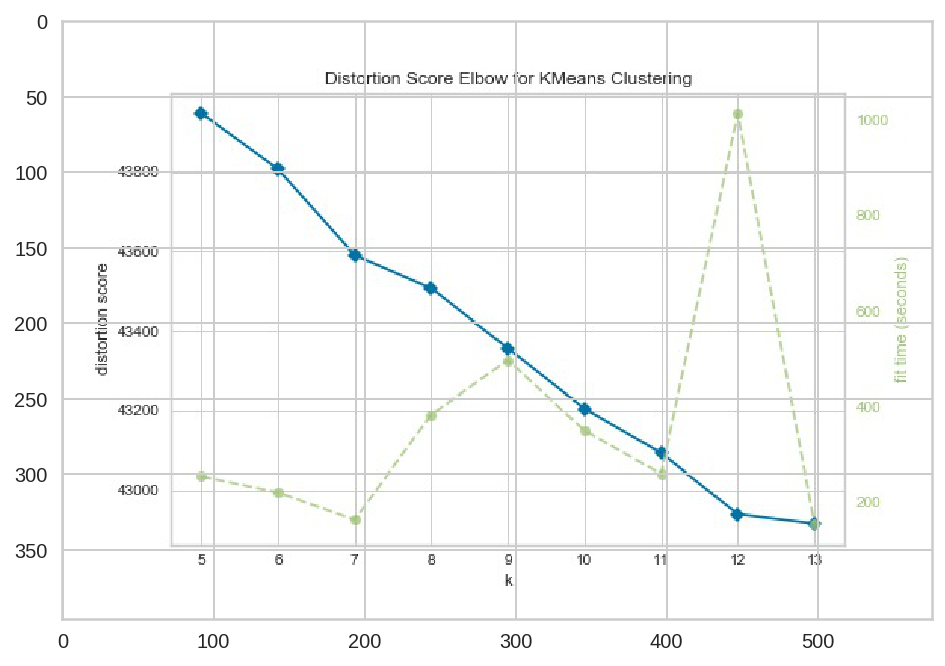

In [4]:
from sklearn.datasets import make_blobs
from sklearn.cluster import KMeans

from yellowbrick.cluster import KElbowVisualizer

def elbowGraph(words_tfIdf):
    # Generate synthetic dataset with 10 random clusters
    X, y = make_blobs(n_samples=1000, n_features=12, centers=10, random_state=42)

    # Instantiate the clustering model and visualizer
    visualizer = KElbowVisualizer(KMeans(n_clusters=10, max_iter = 300, n_init = 1), k=(5,14))

    visualizer.fit(words_tfIdf)

    # Fit the data to the visualizer
    visualizer.show(outpath="elbowGraph.png")

elbowGraph(words_tfIdf)


### 1.2 K-mean clustering:  
- We formed k-mean clustering with k=10.
- This function return the cluster_id for all documnets list.
- Input value= documnet TFIDF

In [ ]:
from sklearn.datasets import make_blobs
from sklearn.cluster import KMeans

def formDocumnetCluster(no_cluster,max_iter,n_init):
    
    kmeans = KMeans(n_clusters=no_cluster, max_iter = max_iter, n_init = n_init)
    y_kmeans=kmeans.fit_predict(words_tfIdf)
    return y_kmeans

cluster_id=formDocumnetCluster(10,300,1);

In [ ]:
#save cluster_id to csv file for future use 
kmeans_df = pd.DataFrame()
kmeans_df['kmeans10']=cluster_id
kmeans_df.to_csv('KmeanData1.csv',index=False)

## <center> Cluster Visualization </center>
<hr>

#### 2.1 Documents in clusters 
- BarChart shows the documnets ditribution among all clusters.
- It shows that size of cluster is varing.
- For example cluster4 has highest documents.

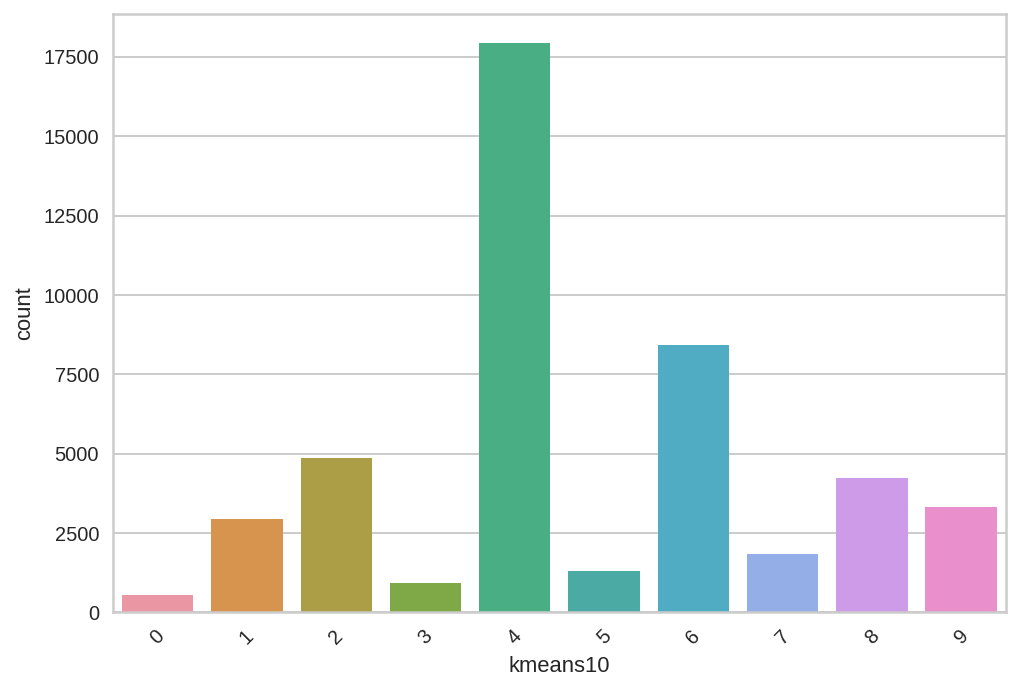

In [5]:

def dataFrameWithClusterId():
    kmeans_df = pd.read_csv('KmeanData.csv')
    #create new dataframe which contain cleaned text,class label,cluster_id
    df_cluster = pd.DataFrame()
    df_cluster['text']=df_cleaned_data['text'];
    df_cluster['clusterId']=kmeans_df['kmeans10'];
    df_cluster['lables']=df_cleaned_data['lables']
    return df_cluster,kmeans_df

# Visualisation of clusters
def clusterVisualize(kmeans_df):
    ax = sns.countplot(x= 'kmeans10', data=kmeans_df)
    ax.set_xticklabels(ax.get_xticklabels(), rotation=45)
    
df_cluster,kmeans_df=dataFrameWithClusterId()  
clusterVisualize(kmeans_df)

#### 2.2  InterCluster Distance Visualization: 
- Intercluster distance maps display an embedding of the cluster centers in 2 dimensions with the distance to other centers preserved.
- It used MDS (Multidimensional Scaling) algorithm as default for it. E.g. the closer to centers are in the visualization, the closer they are in the original feature space. The clusters are sized according to a scoring metric. By default, they are sized by membership, e.g. the number of instances that belong to each center. This gives a sense of the relative importance of clusters. Note however, that because two clusters overlap in the 2D space, it does not imply that they overlap in the original feature space. 
- Referenced from: https://www.scikit-yb.org/en/latest/api/cluster/icdm.html

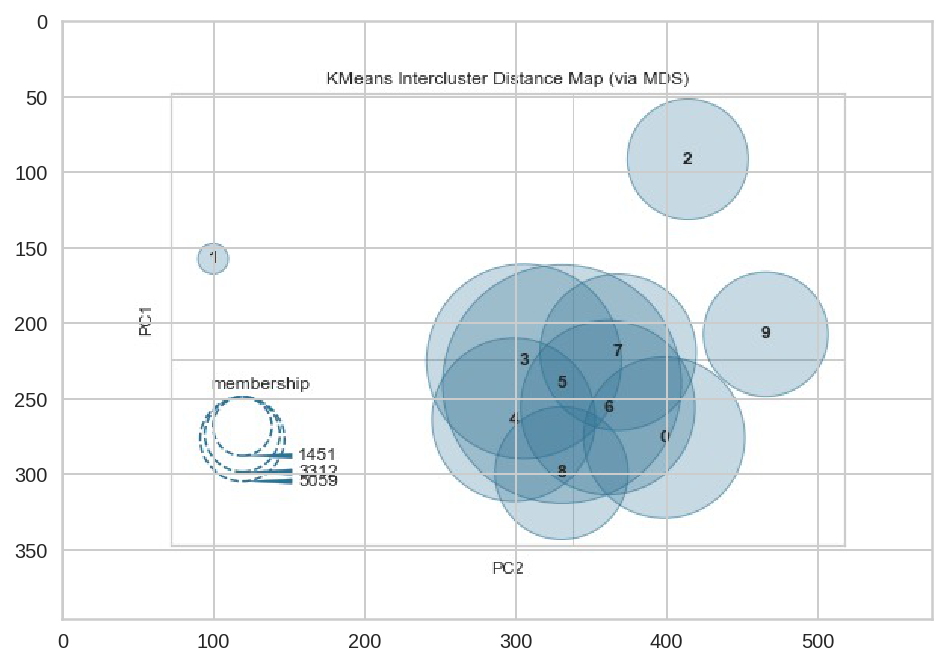

In [6]:
from yellowbrick.cluster import InterclusterDistance
from sklearn.cluster import KMeans
from sklearn.datasets import make_blobs

def KMeanInterClusterGraph():
    # Generate synthetic dataset with 12 random clusters
    X, y = make_blobs(n_samples=1000, n_features=10, centers=10, random_state=42)

    # Instantiate the clustering model and visualizer
    visualizer = InterclusterDistance(KMeans(n_clusters=10, max_iter = 300, n_init = 1))

    visualizer.fit(words_tfIdf)        # Fit the data to the visualizer
    visualizer.show(outpath="KMeanInterClusterGraph.png")
    
KMeanInterClusterGraph()


#### 2.3 t-SNE  : 
- Corpus Visualization To visualize document similarity we have also used t-SNE (t-distributed stochastic neighbor embedding). 
- It decomposes high-dimensional document vectors into 2 dimensions using probability distributions from both the original dimensionality and the decomposed dimensionality, thus effectively able to cluster text documents. It is very expensive, so typically a simpler decomposition method such as SVD or PCA is applied ahead of time. The TSNEVisualizer creates an inner transformer pipeline that applies such a decomposition first (SVD with 50 components by default), then performs the t-SNE embedding. The visualizer then plots the scatter plot, coloring by cluster or by class, or neither if a structural analysis is required.
- We plotted it to identify if any patterns can be obtained from the text corpus among the clusters by projecting it to a 2-D space.
Referenced From: https://www.scikit-yb.org/en/latest/api/text/tsne.html

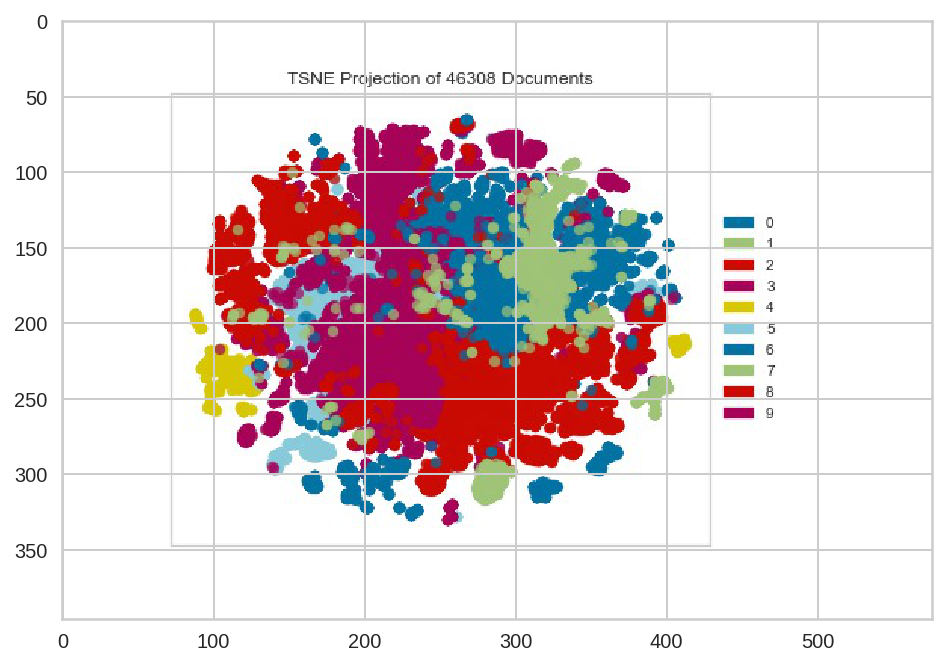

In [7]:
import yellowbrick
import matplotlib.image as mpimg 
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from yellowbrick.text import TSNEVisualizer

def tsneVisualizer(words_tfIdf,cluster_id):
    tsne = TSNEVisualizer()
    tsne.fit(words_tfIdf, cluster_id)
    tsne.show(outpath="tsneVisualizerGraph.png")
tsneVisualizer(words_tfIdf,cluster_id)



## <center>Cluster Evaluation </center>
<hr>

**3.1. Silhouette Coefficient**: 
- As we performed clustering as unsupervised way. (Lables value is unknown), Silhouette score is visual representation of Internal evaluation of cluster.
- Silhouette Score lies between -1 and 1. 
- Higher Silhouette Coefficient score relates to a model with better defined clusters.      (-1) indicate incorrect clustering and +1 for highly dense clustering. 
- Scores around zero indicate overlapping clusters. As the news articles are tagged for multiple topics and our used only the first Topic as Label we recieve a score near to zero.[](http://)

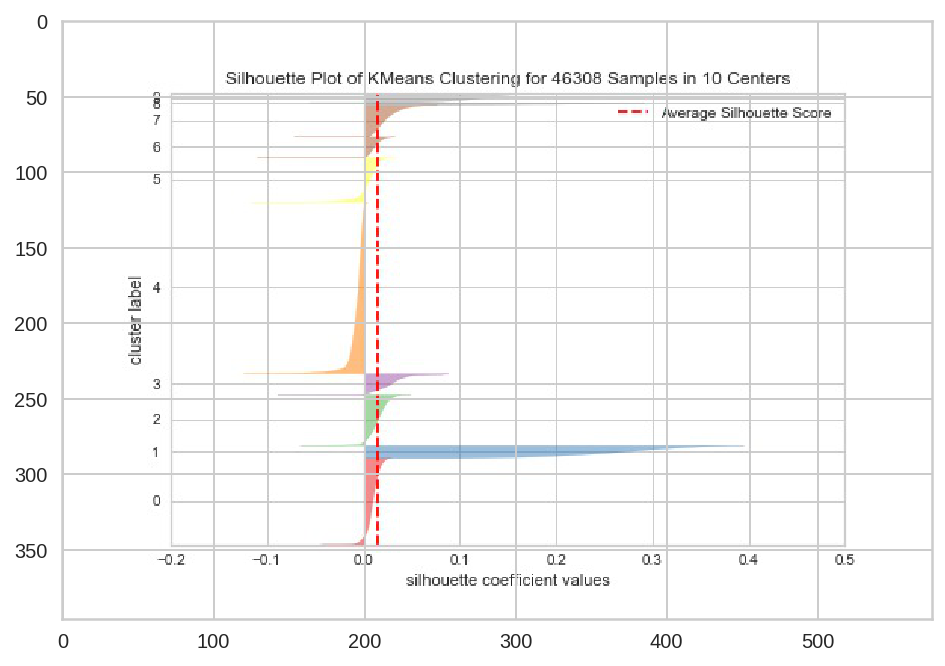

In [8]:
from sklearn import metrics
from sklearn.cluster import KMeans
from yellowbrick.cluster import SilhouetteVisualizer

def plotSilhouetteViz():
    model = SilhouetteVisualizer(KMeans(n_clusters=10, max_iter = 300, n_init = 1))
    model.fit(words_tfIdf)
    model.show(outpath="silhouetteGraph.png")
plotSilhouetteViz()


#### 3.2 . Word Frequency in clusters:
- It shows high frequented words with bigger size.
- We can easily visualized that,In cluster(6) the news are mostly related to government which includes different countries name.
- According to this visualization, we can say that cluster has good accuracy. 

In [9]:
from collections import Counter
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator

def visualizeClusterWords(clusterIndex,cluster_df):
#     cluster_df = df_cluster[df_cluster['clusterId'].apply(lambda X: str(X) == str(clusterIndex))]
    print("Cluster index:",clusterIndex)
    print("Num of records in cluster:", len(cluster_df) )
    word_list = []
    text_data = ""
    for data in cluster_df['text']:
        text_data = text_data +" " +data
        tokenized_word = word_tokenize(data)
        for i in tokenized_word:
            word_list.append(i)
    print("Num of unique words:", len(set(word_list)))
    c = Counter(word_list)

    plotWordCloud(text_data,clusterIndex) 

def plotWordCloud(text,clusterIndex):
    wordcloud = WordCloud(max_font_size=50, max_words=100, background_color="white").generate(text)
    fig = plt.figure()
    fig.suptitle('Cluster '+ str(clusterIndex), fontsize=17)
    fig.subplots_adjust(top=1.1)
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis("off")
    plt.show()

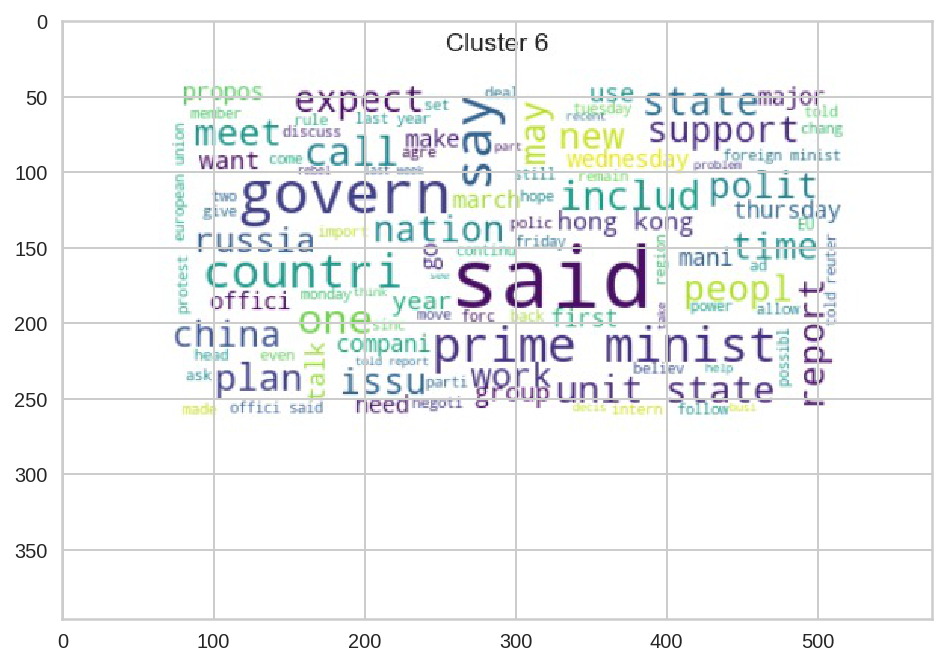

In [10]:
df = df_cluster[df_cluster['clusterId'] == 6]
visualizeClusterWords(6,df)


### Classification Algorithm :
- We merged 3 small clusters and make it one cluster for further process due to very low no of documents.
- we implemented SVM and Randomforest Classification algorithm for every cluster.
- Plot accuracy for both classifier
- Results shows that, small sized clusters have very high accuracy score, which indicate that Average score of classification of Corps higher compare to assignment1.

In [11]:
#merge the small clusters into one cluster.
df_cluster['clusterId'] = df_cluster['clusterId'].replace(0 ,5)
df_cluster['clusterId'] = df_cluster['clusterId'].replace(3, 5)
cluster_id_list=set(list(df_cluster['clusterId']));

In [12]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from sklearn import svm
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import classification_report


#function to get trained model 
def getTrainedClassfier(model,Train_X,Train_Y):
    model=model.fit(Train_X, Train_Y)
    return model

#function to get model accuracy
def getModelAccuracy(model,Test_X,Test_Y):
    predition = model.predict(Test_X)
    accuracy=accuracy_score(Test_Y, predition)
    f_score=f1_score(Test_Y, predition, average='micro')
    print("Accuracy of model",accuracy);
    print("F-score of model",f_score);
    return accuracy,f_score

#function to perform classification algorithms.
def getClassifierAccuracy(x_train,y_train,x_test,y_test):
    model_names = []
    model_acc = []
    model_f1 = []
    #SVM model 
    svm_model =svm.SVC(kernel="linear",gamma='auto')
    svm_model=getTrainedClassfier(svm_model,x_train,y_train)
    print("SVM model:")
    model_names.append('SVM')
    Accuracy,f_score=getModelAccuracy(svm_model,x_test,y_test)
    model_acc.append(Accuracy)
    model_f1.append(f_score)

    #Random forest model
    randomForest_model = RandomForestClassifier(n_estimators=100,random_state=0)
    randomForest_model=getTrainedClassfier(randomForest_model,x_train,y_train)
    print("Random forest model:")
    model_names.append('RandomForest')
    Accuracy,f_score=getModelAccuracy(randomForest_model,x_test,y_test)
    model_acc.append(Accuracy)
    model_f1.append(f_score)
    plotModelComparisons(model_names,model_acc,model_f1)

# Functions to implement plot to compare accuracy of all clusters.
def plotModelComparisons(model_names,model_acc,model_f1):
    x = np.arange(len(model_names))  # the label locations
    width = 0.30  # the width of the bars
    fig, ax = plt.subplots(figsize=(13,7))
    rects1 = ax.bar(x - width/2, model_acc, width, label='Accuracy')
    rects2 = ax.bar(x + width/2, model_f1, width, label='F1 Score')
    ax.set_ylabel('Validation Scores',fontsize=15)
    ax.set_xlabel('Classifiers',fontsize=15)
    ax.set_title('Model Comparison', fontsize=18)
    ax.set_xticks(x)
    ax.set_xticklabels(model_names)
    ax.legend()
    def autolabel(rects):
        for rect in rects:
            height = rect.get_height()
            ax.annotate('{0:.3f}'.format(height*100)+" %",
                        xy=(rect.get_x() + rect.get_width() / 2, height),
                        xytext=(0, 3),  # 3 points vertical offset
                        textcoords="offset points",
                        ha='center', va='bottom', fontsize=13)


    autolabel(rects1)
    autolabel(rects2)
    fig.tight_layout()
    plt.show()

Classification with cluster: 1 With records 2947
SVM model:
Accuracy of model 0.7220338983050848
F-score of model 0.7220338983050848
Random forest model:
Accuracy of model 0.6361581920903955
F-score of model 0.6361581920903955


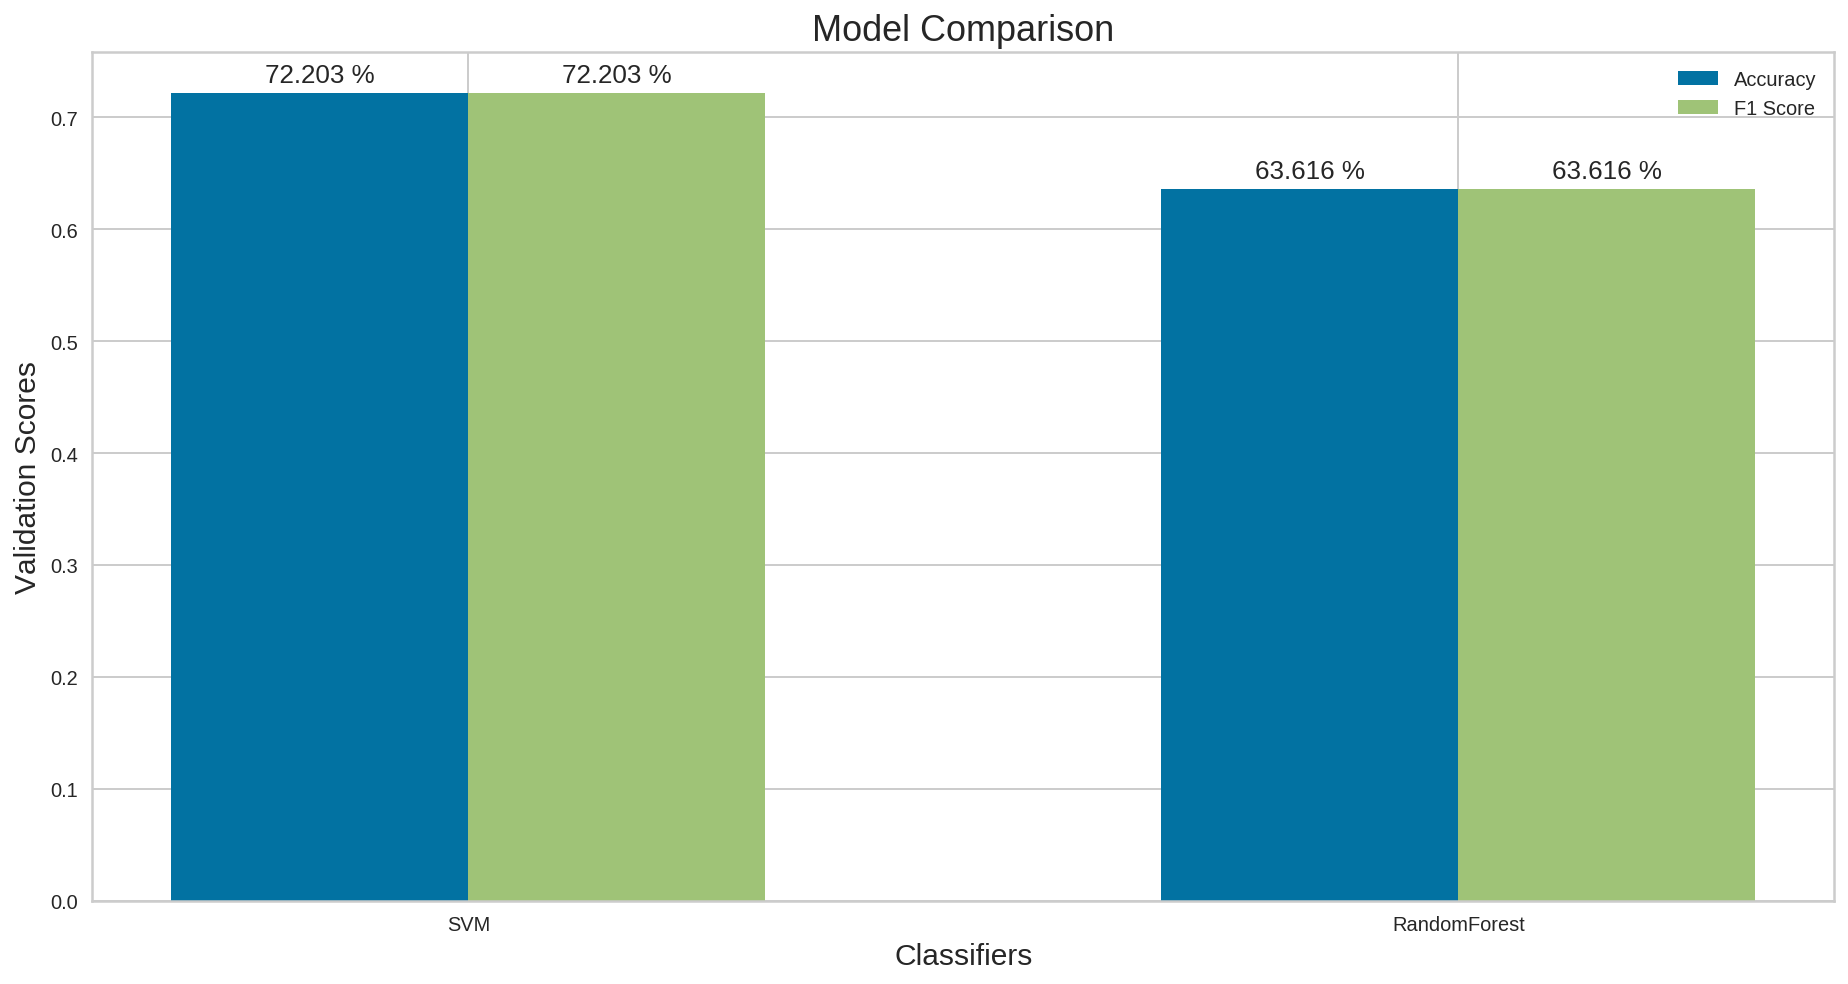

**********************************
Classification with cluster: 2 With records 4845
SVM model:
Accuracy of model 0.7716643741403026
F-score of model 0.7716643741403026
Random forest model:
Accuracy of model 0.7125171939477304
F-score of model 0.7125171939477304


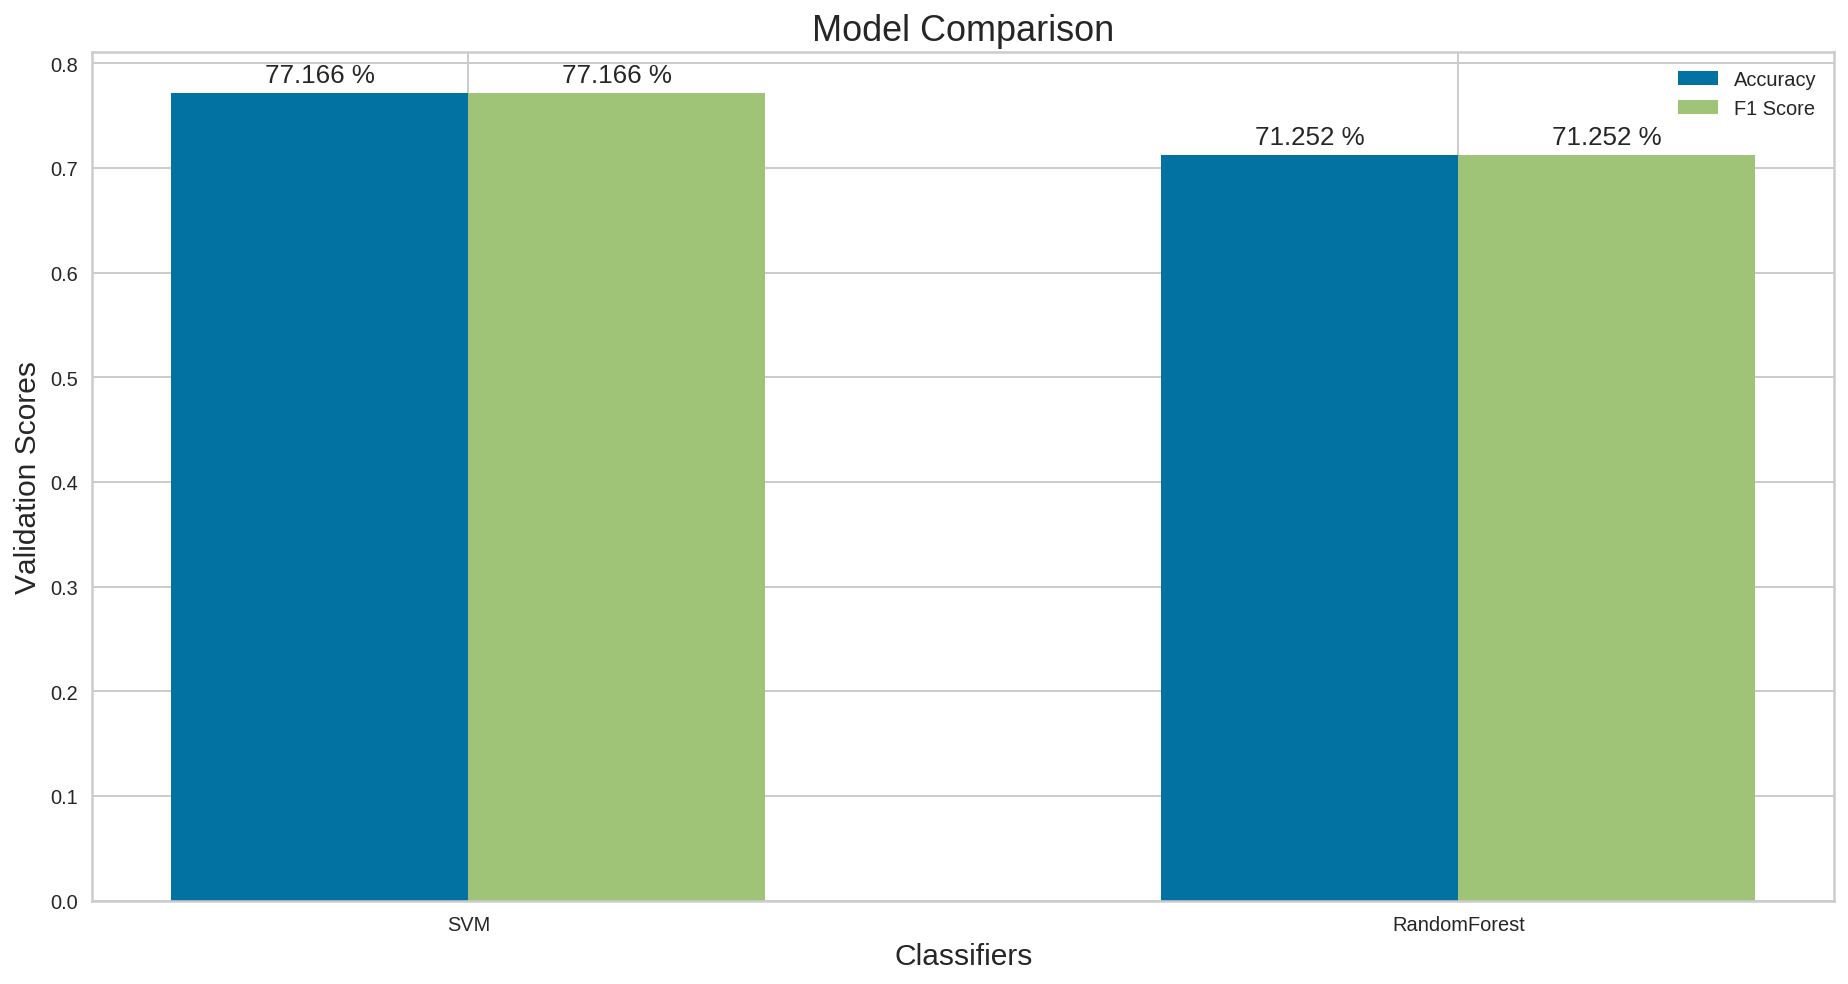

**********************************
Classification with cluster: 4 With records 17945
SVM model:
Accuracy of model 0.7416419019316494
F-score of model 0.7416419019316494
Random forest model:
Accuracy of model 0.6664190193164933
F-score of model 0.6664190193164933


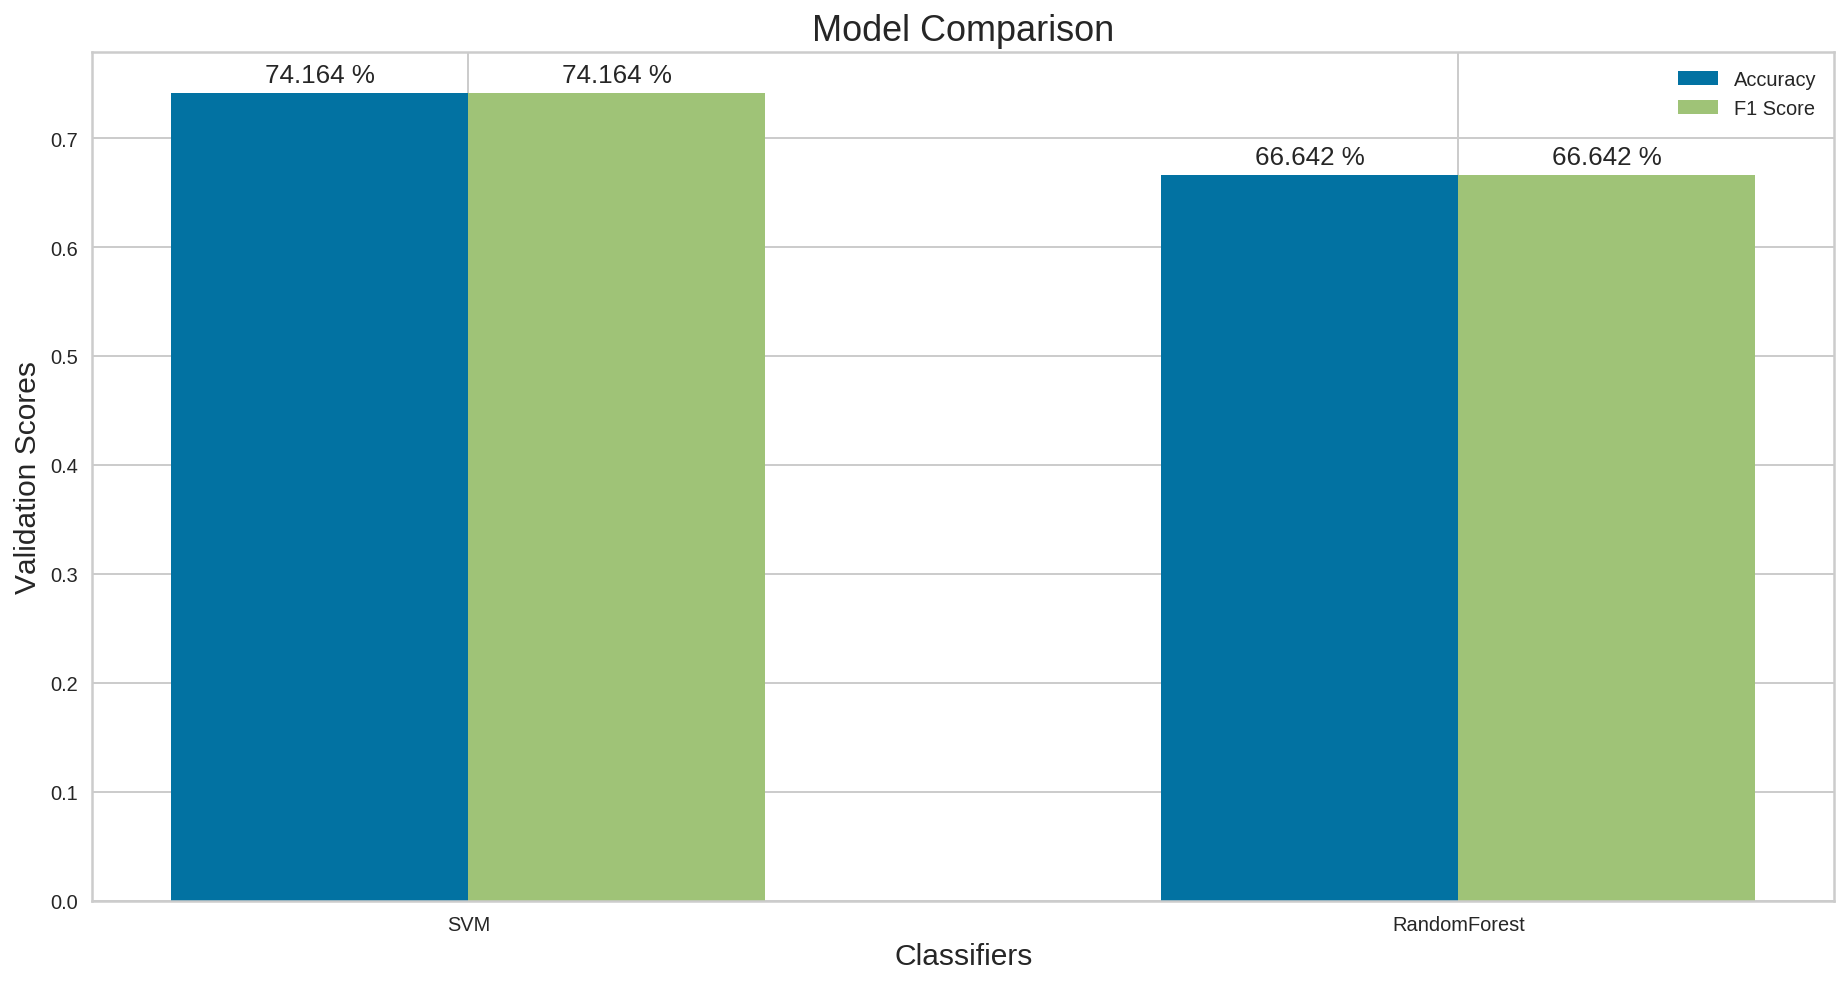

**********************************
Classification with cluster: 5 With records 2775
SVM model:
Accuracy of model 0.9711884753901561
F-score of model 0.9711884753901561
Random forest model:
Accuracy of model 0.9675870348139256
F-score of model 0.9675870348139256


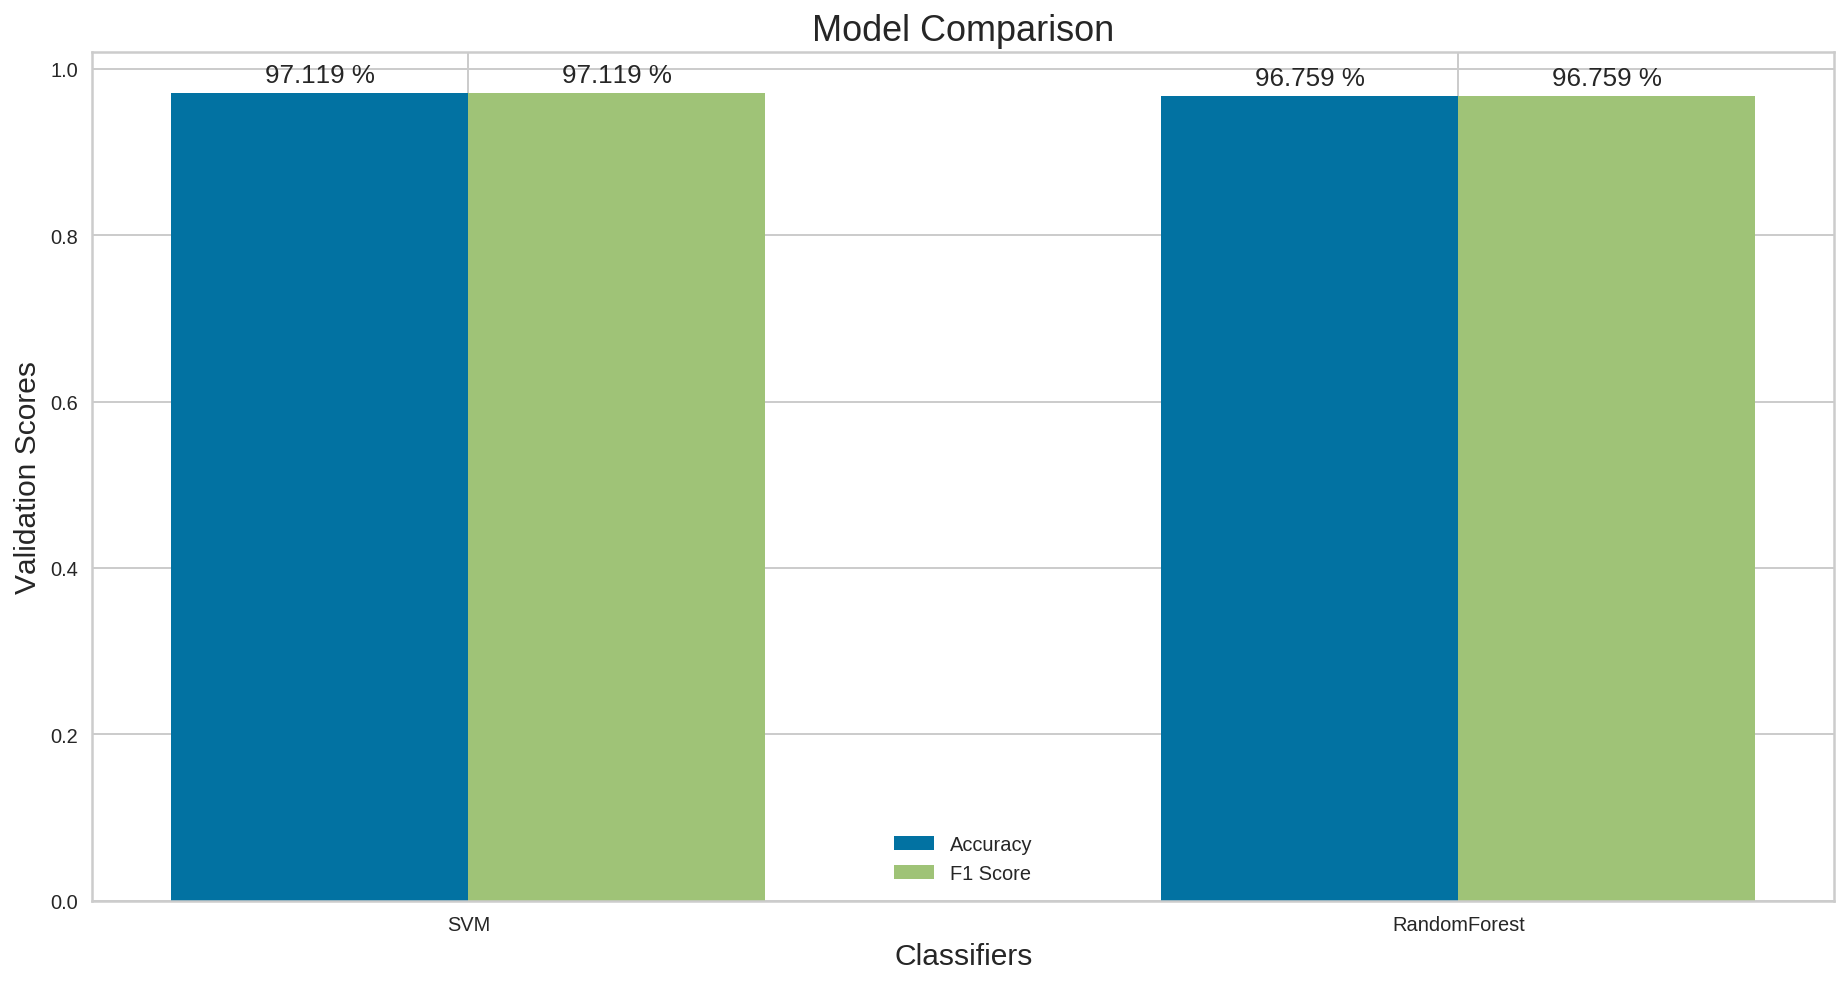

**********************************
Classification with cluster: 6 With records 8428
SVM model:
Accuracy of model 0.8109924871490708
F-score of model 0.8109924871490707
Random forest model:
Accuracy of model 0.734282325029656
F-score of model 0.734282325029656


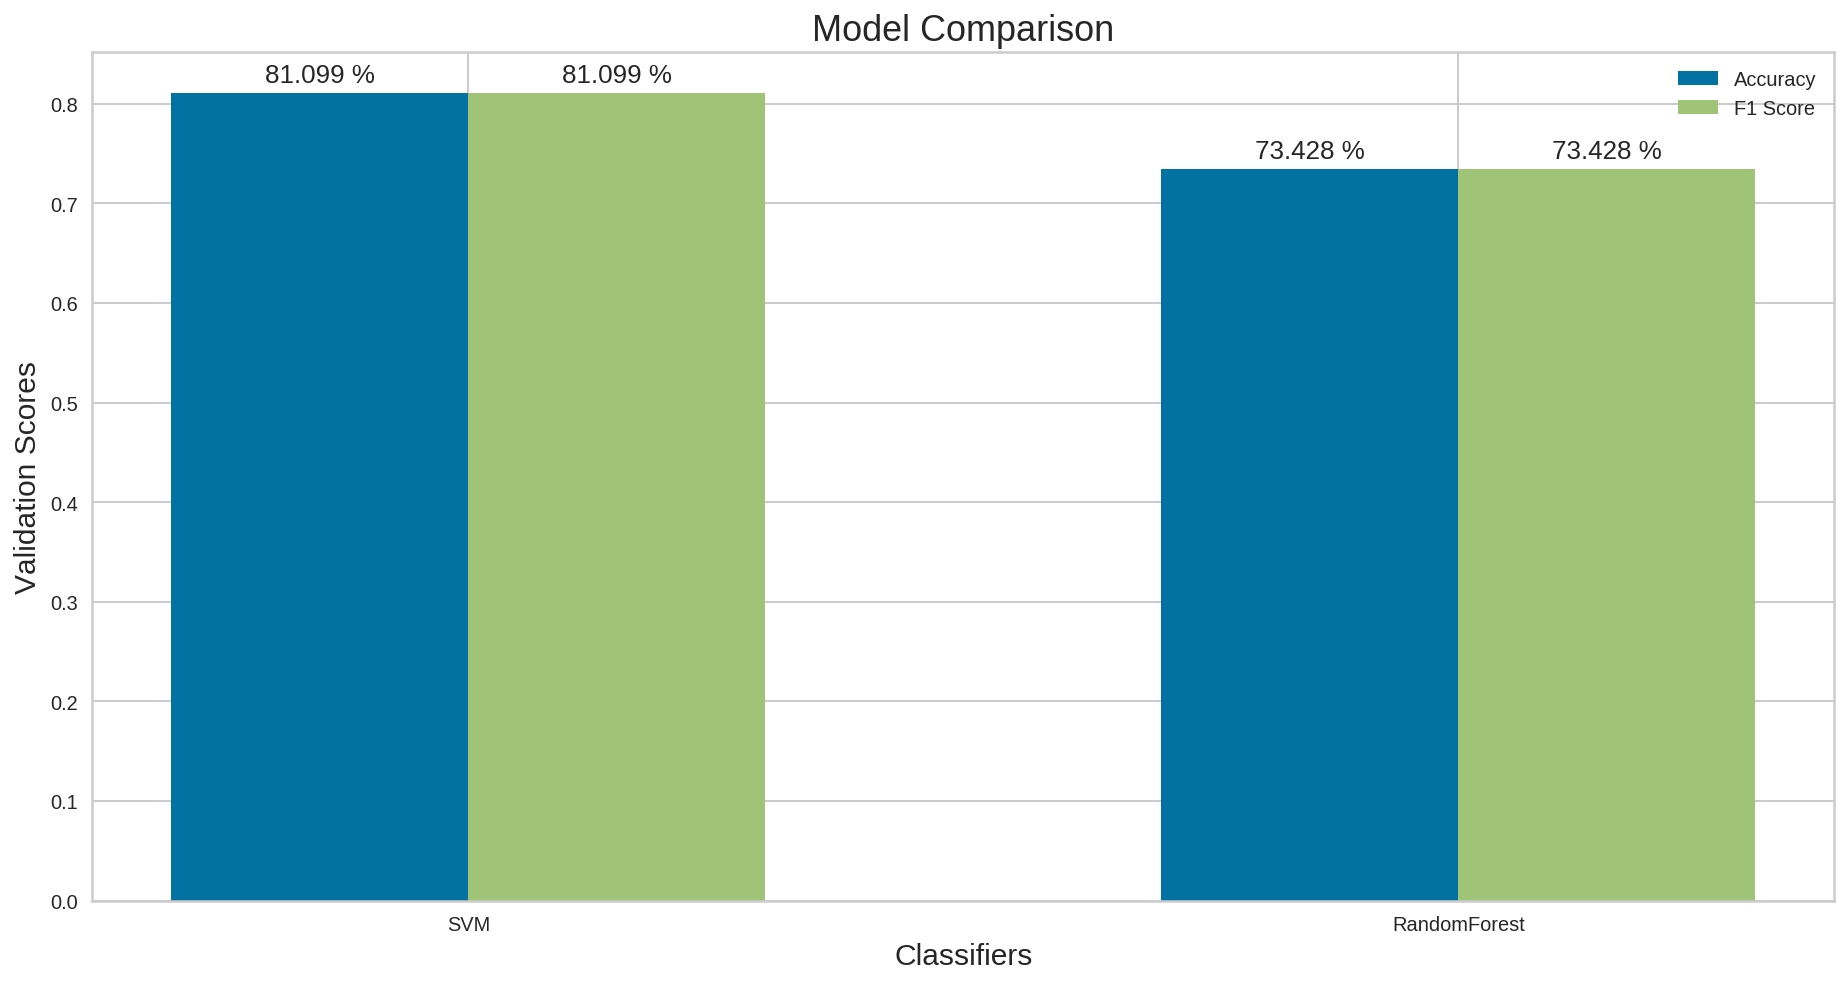

**********************************
Classification with cluster: 7 With records 1822
SVM model:
Accuracy of model 0.923217550274223
F-score of model 0.923217550274223
Random forest model:
Accuracy of model 0.906764168190128
F-score of model 0.906764168190128


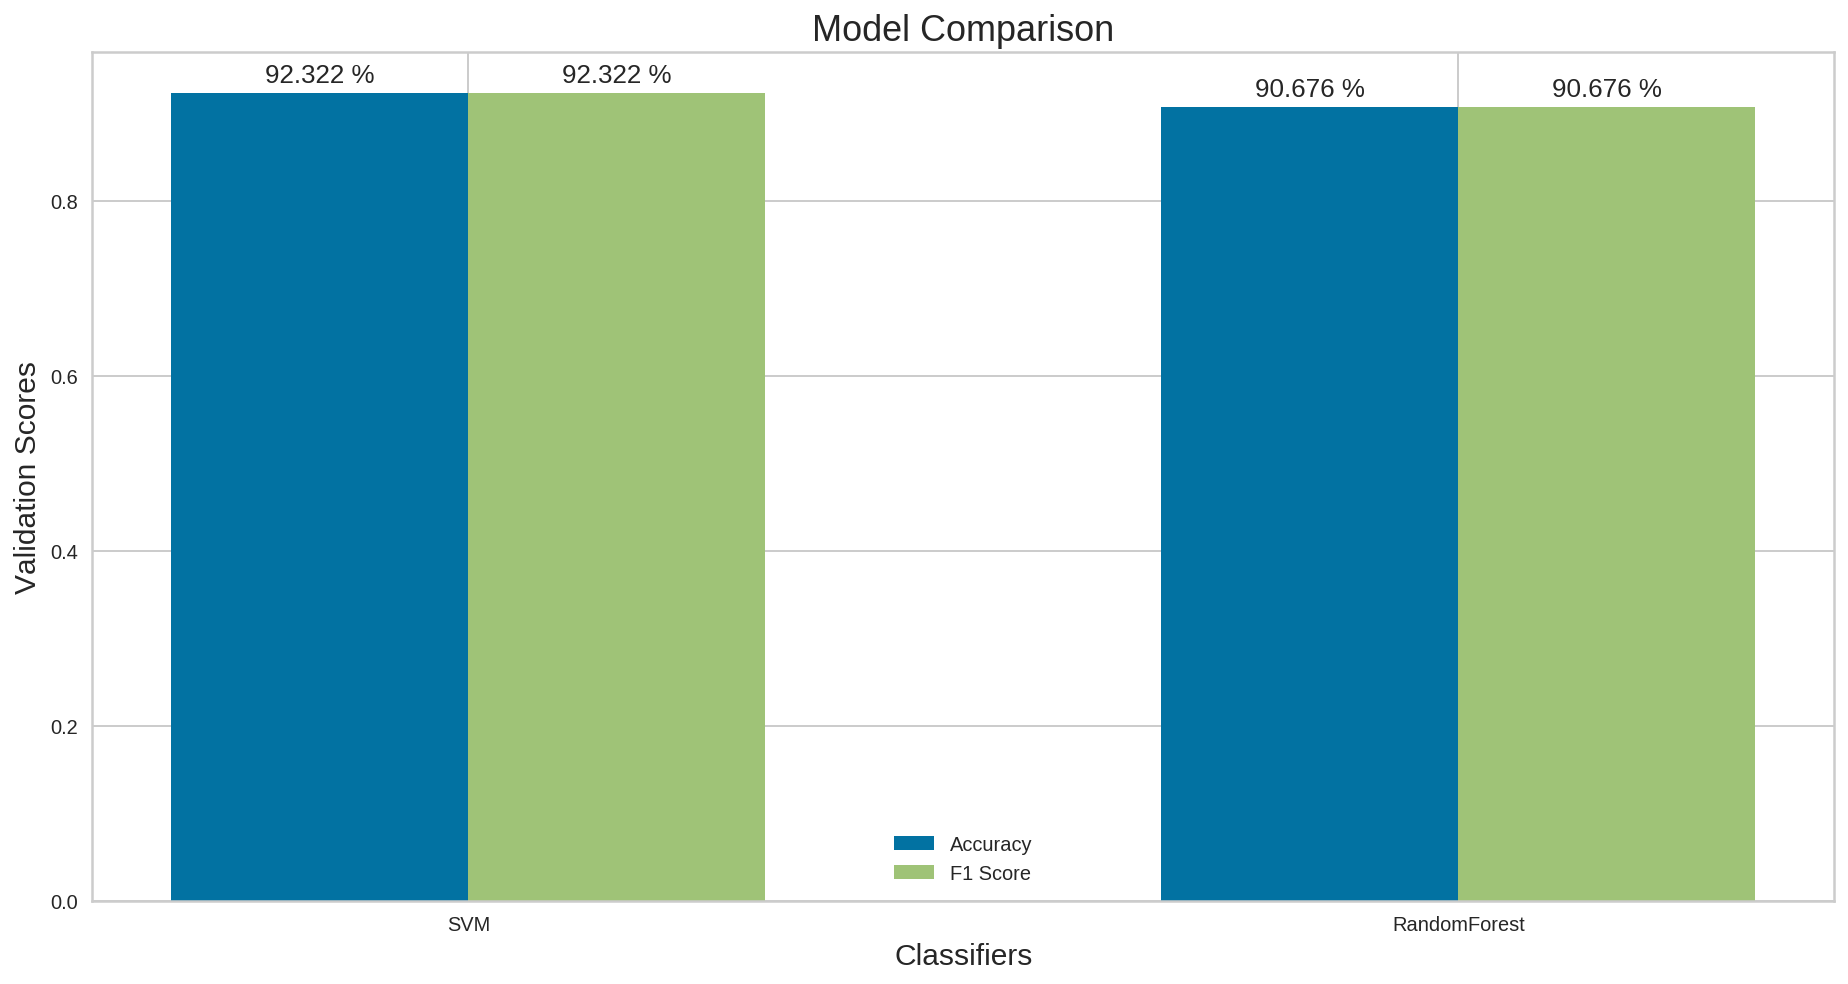

**********************************
Classification with cluster: 8 With records 4221
SVM model:
Accuracy of model 0.8413575374901342
F-score of model 0.8413575374901342
Random forest model:
Accuracy of model 0.7908445146014207
F-score of model 0.7908445146014207


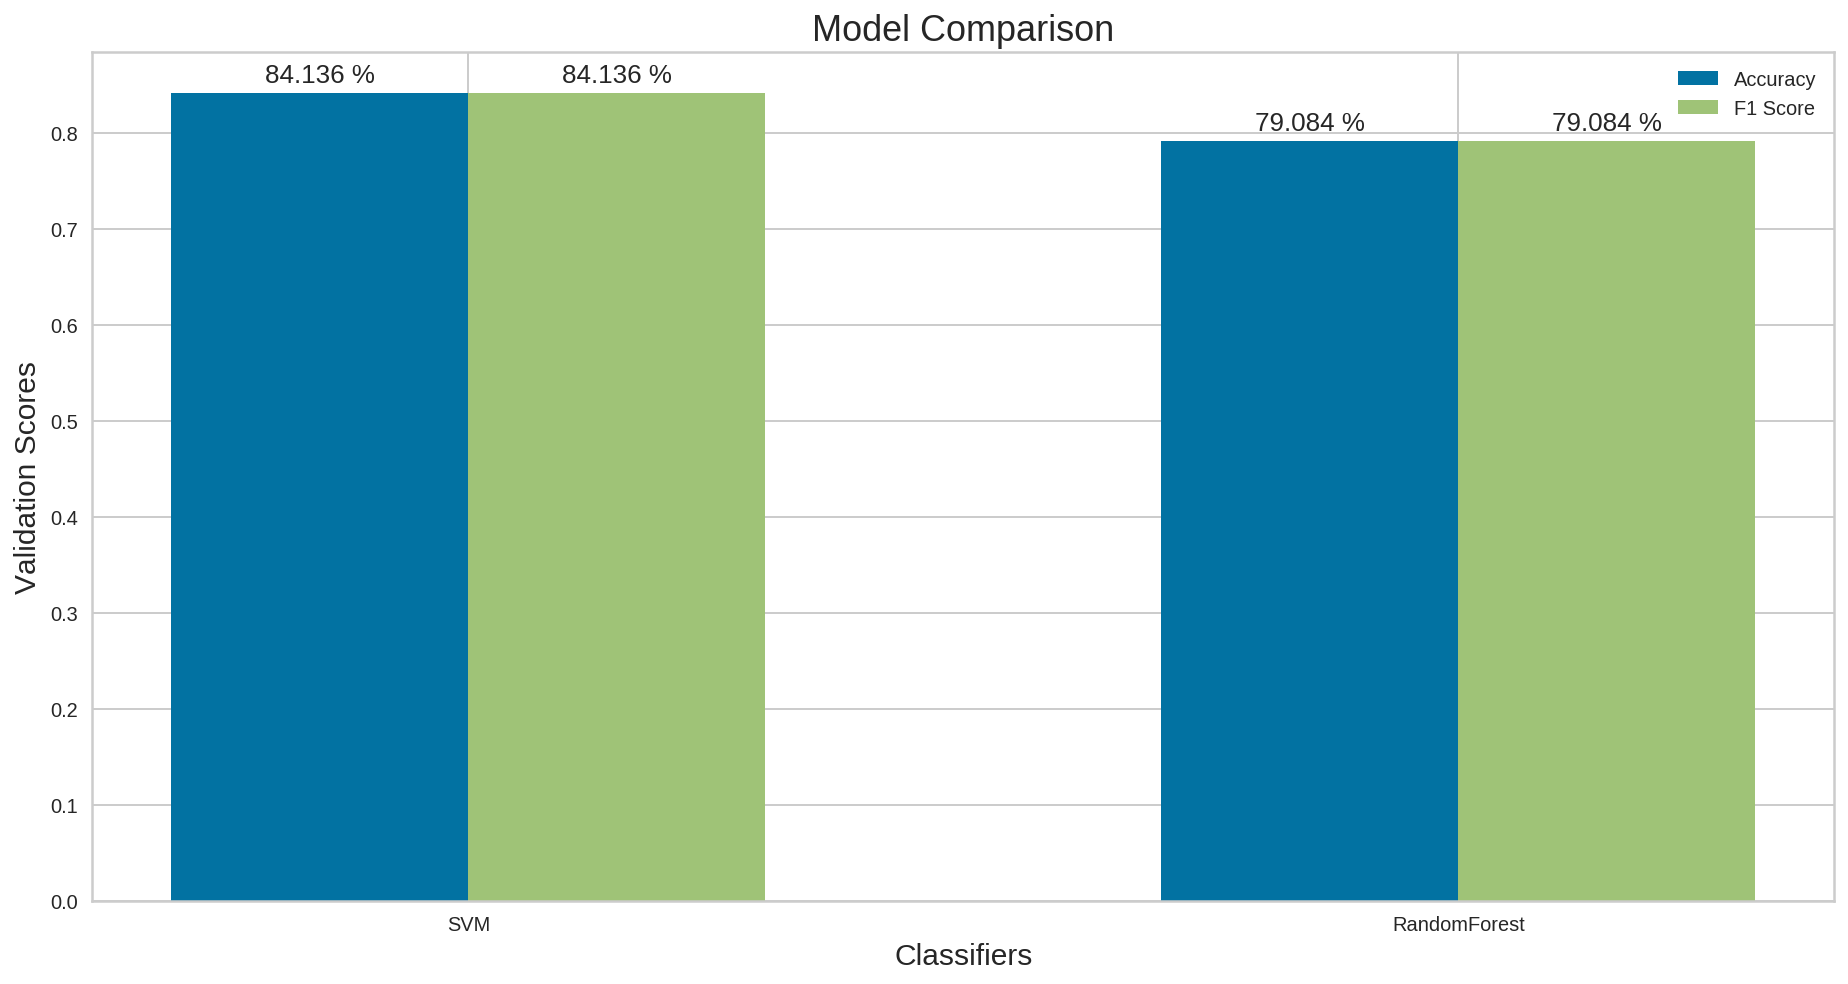

**********************************
Classification with cluster: 9 With records 3325
SVM model:
Accuracy of model 0.8597194388777555
F-score of model 0.8597194388777556
Random forest model:
Accuracy of model 0.8326653306613226
F-score of model 0.8326653306613226


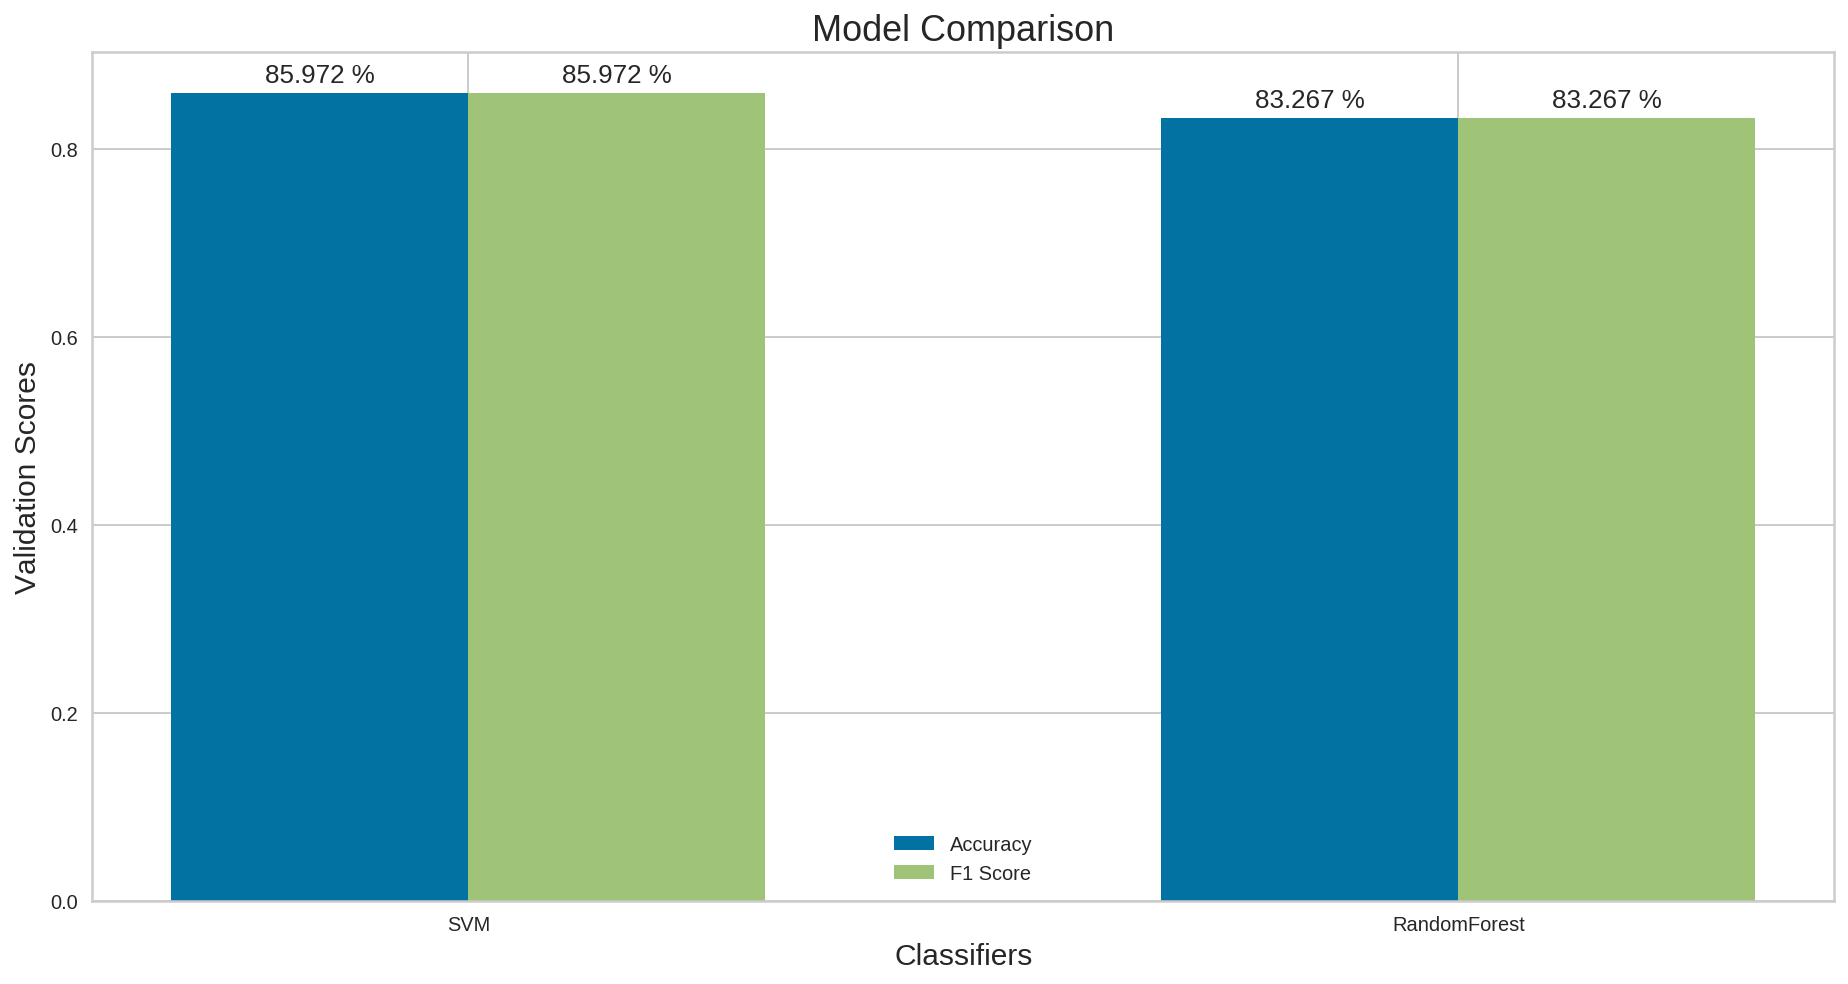

**********************************


In [13]:

from sklearn.model_selection import train_test_split

for i in cluster_id_list:
    cluster_data=df_cluster[df_cluster['clusterId'].apply(lambda X: str(X) == str(i))]
    vectorizer = TfidfVectorizer()
    words_tfIdf_cluster = vectorizer.fit_transform(cluster_data['text'])
    x_train, x_test, y_train, y_test =train_test_split(words_tfIdf_cluster,cluster_data['lables'],test_size=0.3)
    print("Classification with cluster:",i,"With records",len(cluster_data))
    getClassifierAccuracy(x_train,y_train,x_test,y_test)
    print("**********************************")

## <center> Feature Extraction </center> ##
<hr>

**1. Refered Paper :**

[Paper 1]Liang, Hong et al. “Text feature extraction based on deep learning: a review.”EURASIP journal on wireless communications and networkingvol. 2017,1 (2017): 211. doi:10.1186/s13638-017-0993-1

**Feature Extraction**: Feature extraction can improve the accuracy of learning algorithm and decrease the time by reducing the dimensionality of feature vector spaces.

#### Suggested Solutions in Paper :

1. Word frequency
2. Mutual information
3. Mapping methods
4. Deep learning approach using Autoencoder

According to this paper, Deep learning approach for feature selection is better compared to other mentioned methods. Deep learning is able to detect complicated features interactions.



#### Autoencoder:
- An autoencoder has numerous hidden layers between input and output layer.
- A hidden layer usually has a more compressed representation than input and output layers.
- Hidden layer has fewer units than input or output layer.

### Autoencoder Implementation:

- We've have used 'Dense' type hidden layers between input and output layers.
- Activation function: The activation function of a node in neural network calculate the output of that node based on input values.
  - We've used 'tanh' activation function in hidden layers, as found to work better from hyper-parameter tuning.
  - We've used Sigmoid activation function in output layers, which gave output in range (0,1)
- We've extracted 60% important features using autoencoder.
- Input Data: Training data works as the input to autoencoder , input_size= no of features in training data 
- Loss_function : In neural networks, Loss function helps to optimize the parameters of the network. We've used binary_crossentropy as loss function as it serves better to be used as loss function with a sigmoid activation unit in output layer.
- We tried different values of activation functions and dense layer sizes to figure out values that gave better accuracy.

In [14]:
def getExtractedFeature(x_train,x_test):
    
    # Input_size = no of features in train data set 
    input_size = x_train.shape[1]
    input_data = Input(shape=(input_size,))
    
    #took 2/3th features from input layer to hidden layer
    a=int(input_size/1.5)
    encoded = Dense(a, activation='tanh')(input_data)
    a=int(a/1.5)
    #took 2/3th features from hidden layer to other hidden layer
    
    #Encoded layer is middle layer which contain the extracted features 
    encoded = Dense(a, activation='tanh')(encoded)

    a=int(a*1.5)
    
    # Reverse process of encoding and try to recreate the input features
    decoded = Dense(a, activation='tanh')(encoded)
    
    #Output layer as decoded 
    decoded = Dense(input_size, activation='sigmoid')(decoded)

    autoencoder_model = Model(input_data, decoded)
    
    #compile model to identify loss
    autoencoder_model.compile(optimizer='adadelta', loss='binary_crossentropy')
    autoencoder_model.fit(x_train, x_train,
                    epochs=3,
                    batch_size=500,
                    shuffle=True,
                    validation_data=(x_test, x_test),verbose=False)
    
    # get extracted features 
    encoder_layer = Model(input_data, encoded)
    
    #extracted train data
    data_train=encoder_layer.predict(x_train)
    
    #extracted test data
    data_test=encoder_layer.predict(x_test)
 
    return data_train,data_test

## <center>Deep Neural Network</center>

- We implemented Deep neural network.
- Input data : We used traing data as input data, Input_size=traing data features
- Activation function : The activation function of a node in neural network calculate the output of that node based on input values.
  - Softmax : This is multiclass classification problem, it maps the last layer of the network to a vector of K probabilities(no of classes)
- Loss function : categorical_crossentropy, As mentioned before we have multiclass problem categorical_crossentropy is better as loss function with it.

* Reference* : https://realpython.com/python-keras-text-classification/ 

In [15]:
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation

# function of deep neural network
def neuralNetworkFunction(x_train,x_test,y_train,y_test,num_classes):
    
    #Input data shape= No of features in training dataset
    input_shape=x_train.shape[1]
    
    #Deep network
    model = Sequential()
    model.add(Dense(1000, input_shape=(input_shape,)))
    model.add(Activation('elu'))
    model.add(Dense(500))
    model.add(Activation('elu'))
    model.add(Dropout(0.5))
    model.add(Dense(num_classes))
    model.add(Activation('softmax'))
    
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    
    #fit train data
    history = model.fit(x_train, y_train, batch_size=32, epochs=5, verbose=False, validation_split=0.1)
    
    #Evaluate models using hold out data.
    test_accuracy = model.evaluate(x_test,y_test, batch_size=32)
    
    #plot graph which shows accuracy and loss of train and test data.
    plot_history_graph(history)
    print('Test accuracy:', test_accuracy[1])

In [16]:
import matplotlib.pyplot as plot
plot.style.use('ggplot')

def plot_history_graph(history):
    
    #Accuracy of model 
    value_accuracy = history.history['val_accuracy']
    accuracy = history.history['accuracy']
    
    #Loss of model
    value_loss = history.history['val_loss']
    loss_value = history.history['loss']
   
    #Range of x axis.
    x = range(1, len(accuracy) + 1)

    plot.figure(figsize=(13, 6))
    plot.subplot(1, 2, 1)
    
    plot.plot(x, accuracy, 'b', label='Training Accuracy')
    plot.plot(x, value_accuracy, 'r', label='Validation Accuracy')
    
    plot.title('Training and validation Accuracy')
    plot.legend()
    
    plot.subplot(1, 2, 2)
    plot.plot(x, loss_value, 'b', label='Training loss')
    plot.plot(x, value_loss, 'r', label='Validation loss')
    
    plot.title('Training and validation loss')
    plot.legend()
    plot.show()
    
# reference : https://realpython.com/python-keras-text-classification/ 

### Approach 1:  Deep neural network 

cluster data with clusterId 1
size of data 2947
885/885 [==============================] - 0s 75us/step


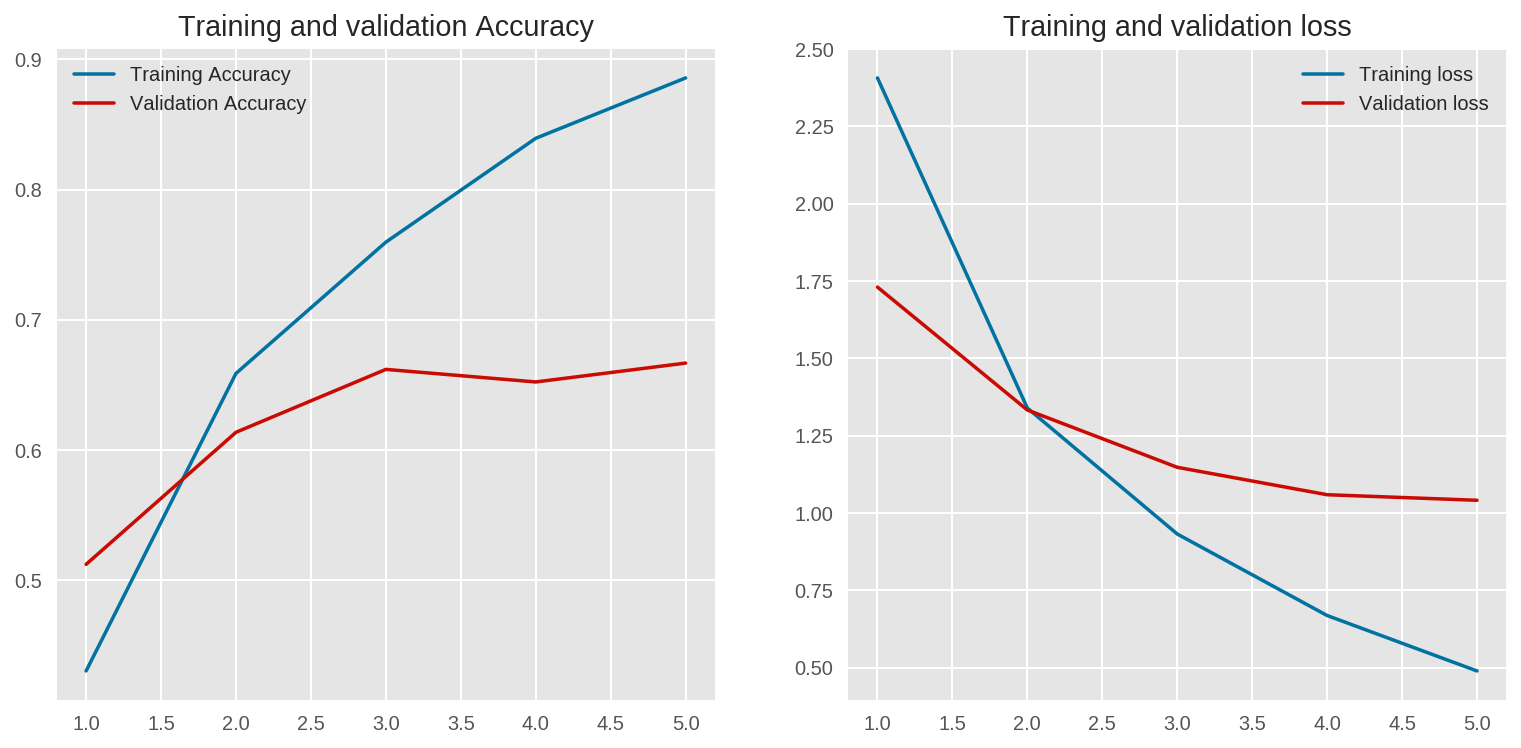

Test accuracy: 0.7152542471885681
cluster data with clusterId 2
size of data 4845
1454/1454 [==============================] - 0s 68us/step


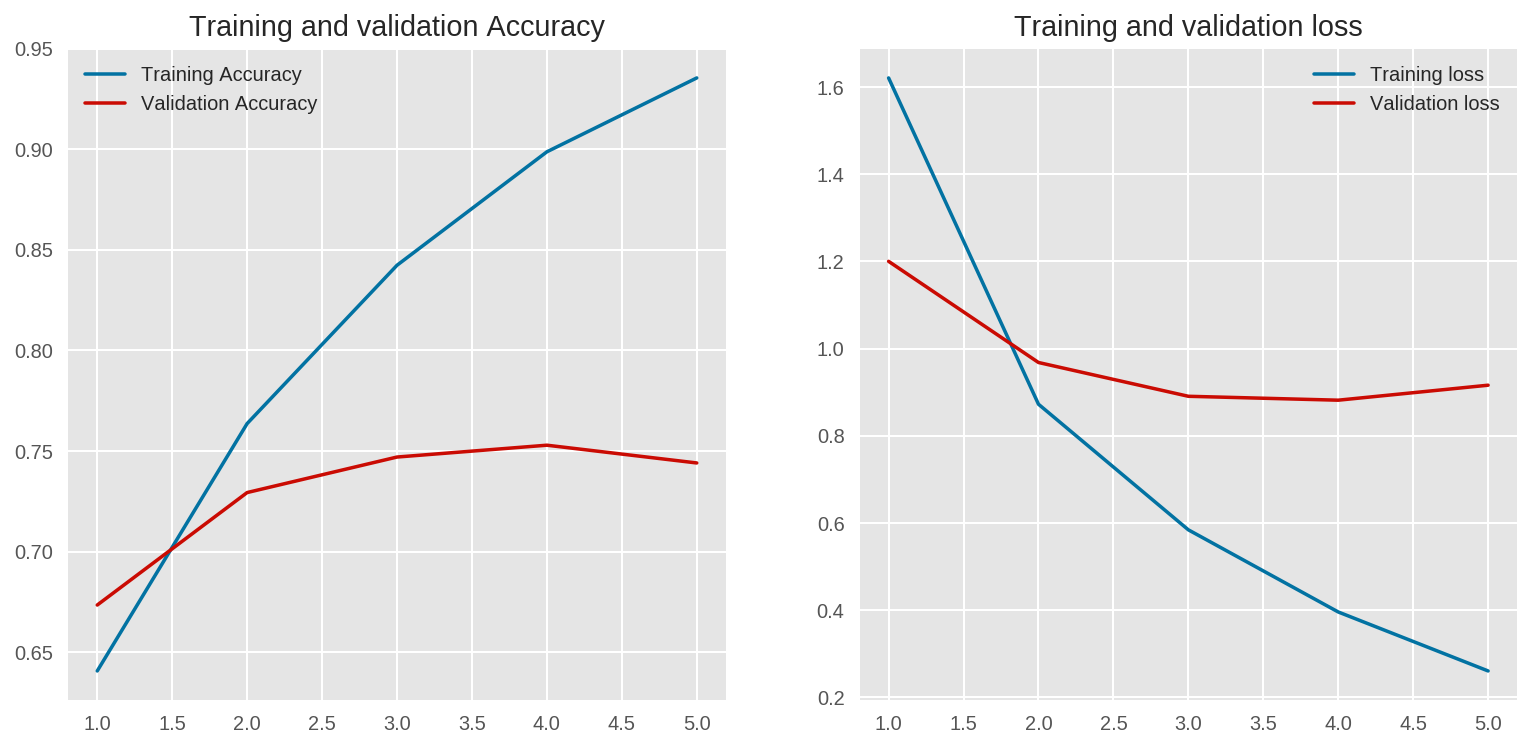

Test accuracy: 0.7696011066436768
cluster data with clusterId 4
size of data 17945
5384/5384 [==============================] - 0s 66us/step


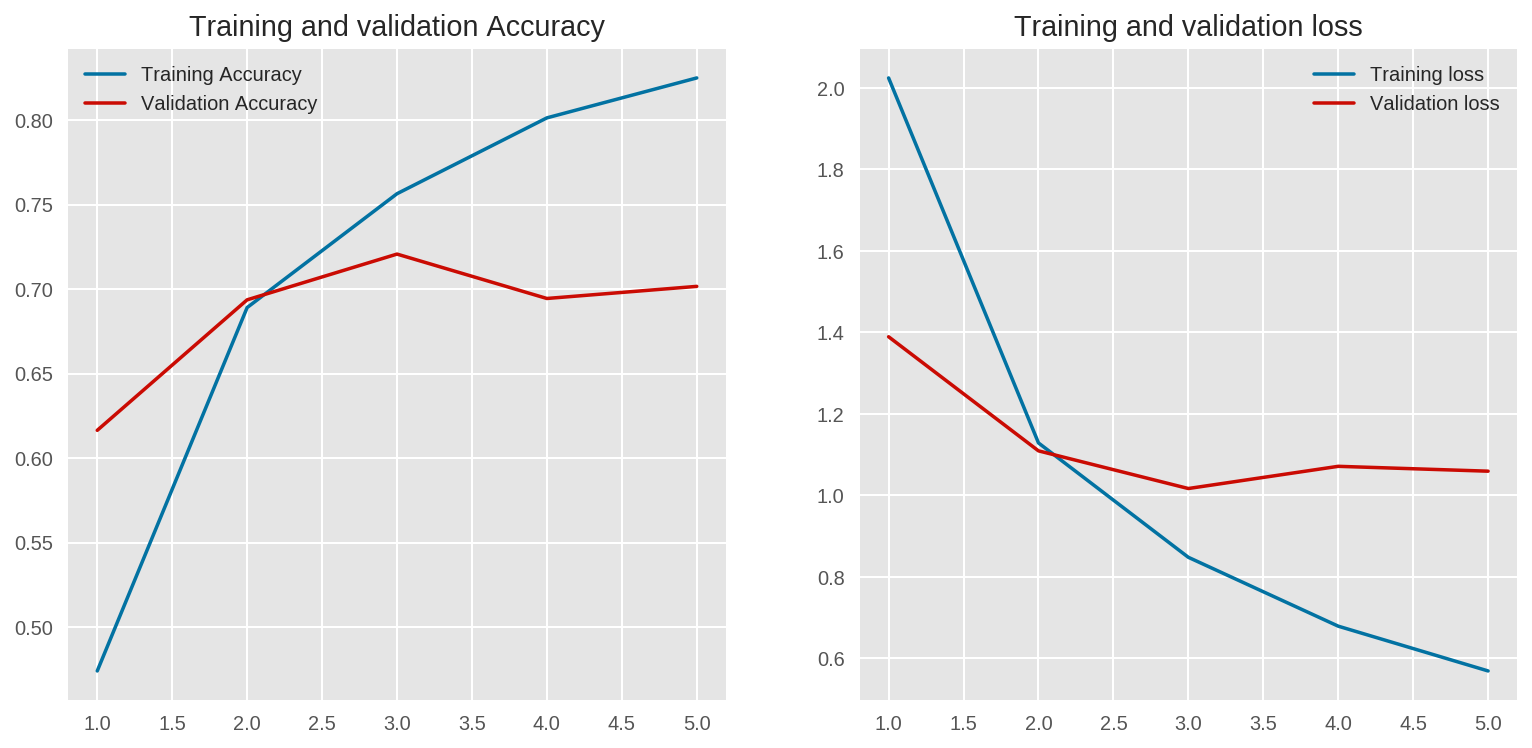

Test accuracy: 0.6927934885025024
cluster data with clusterId 5
size of data 2775
833/833 [==============================] - 0s 70us/step


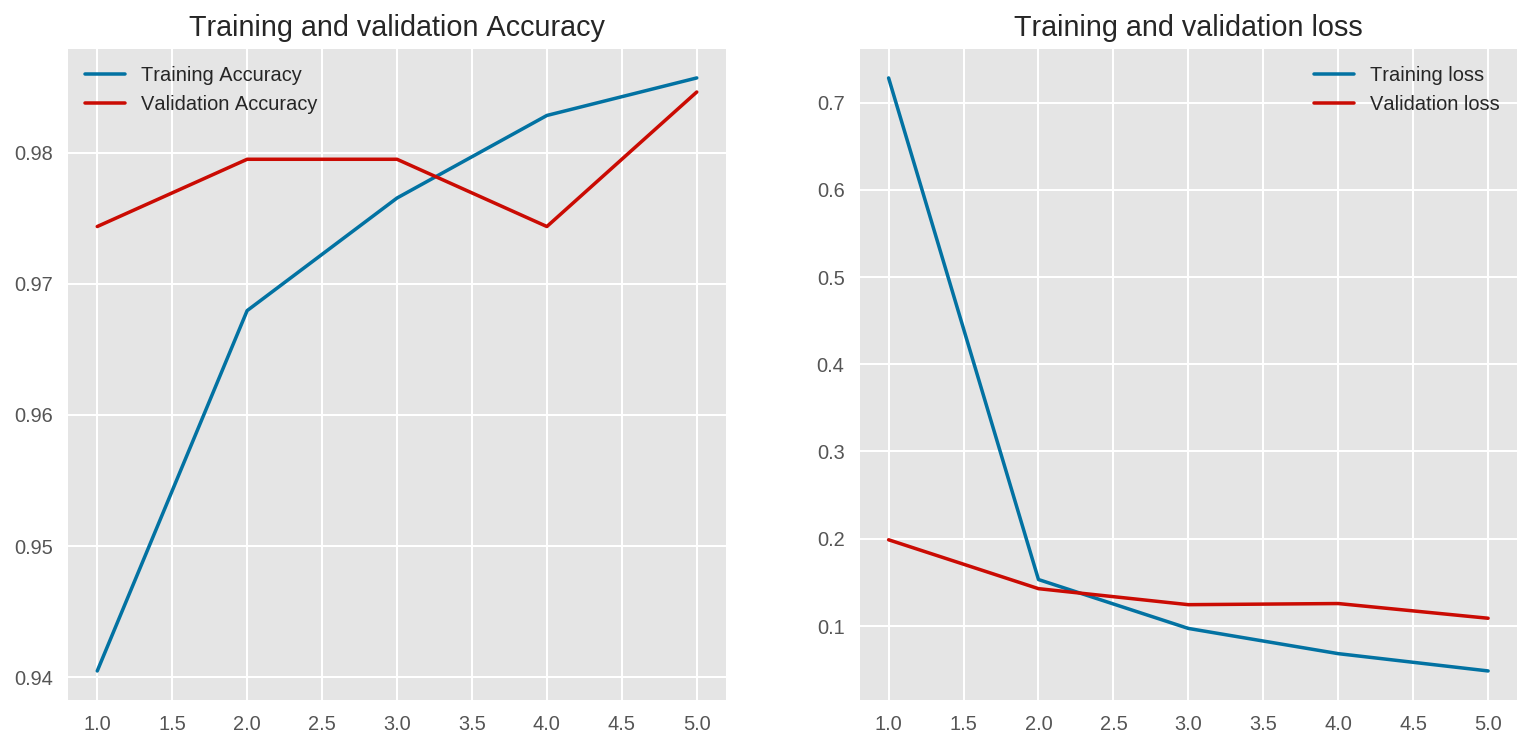

Test accuracy: 0.9783913493156433
cluster data with clusterId 6
size of data 8428
2529/2529 [==============================] - 0s 70us/step


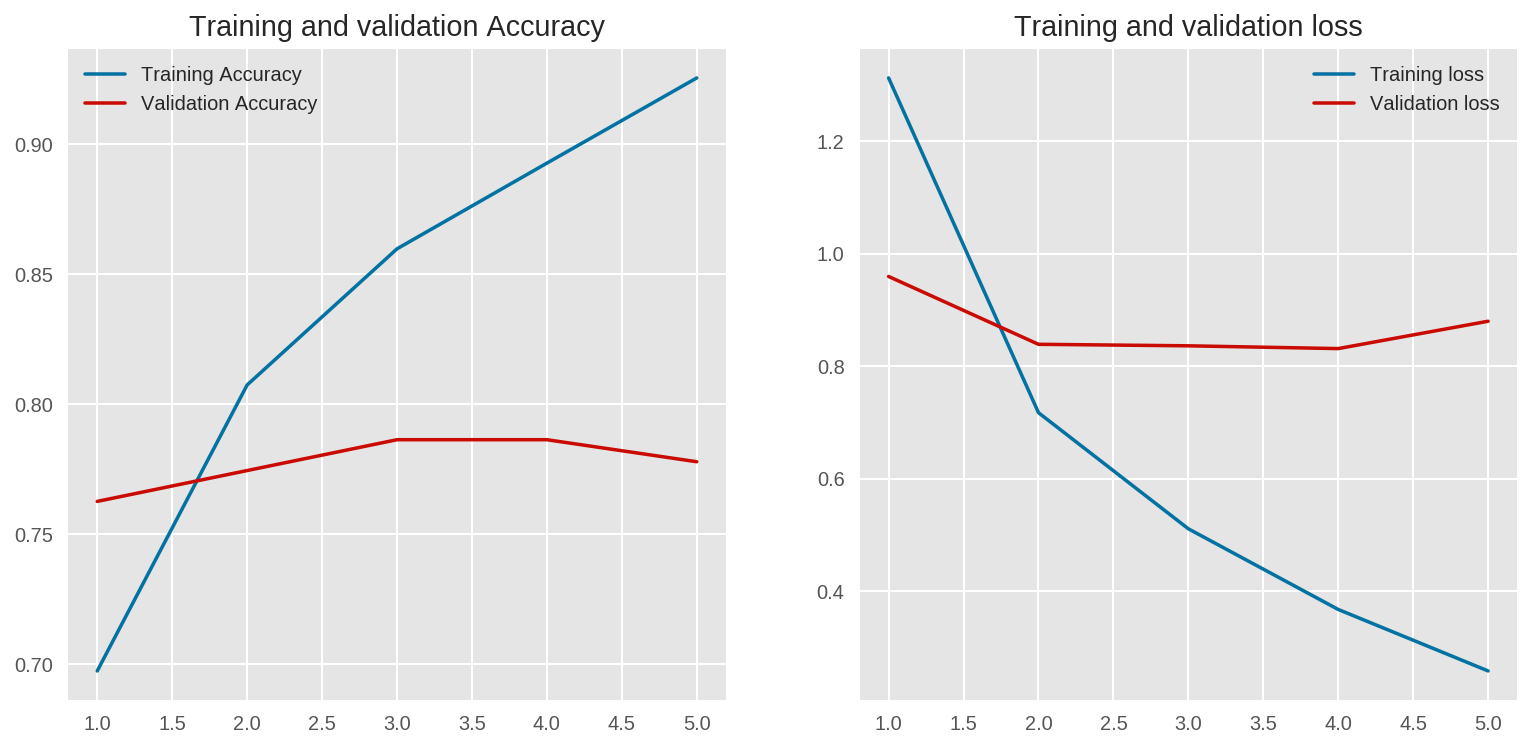

Test accuracy: 0.7884539365768433
cluster data with clusterId 7
size of data 1822
547/547 [==============================] - 0s 84us/step


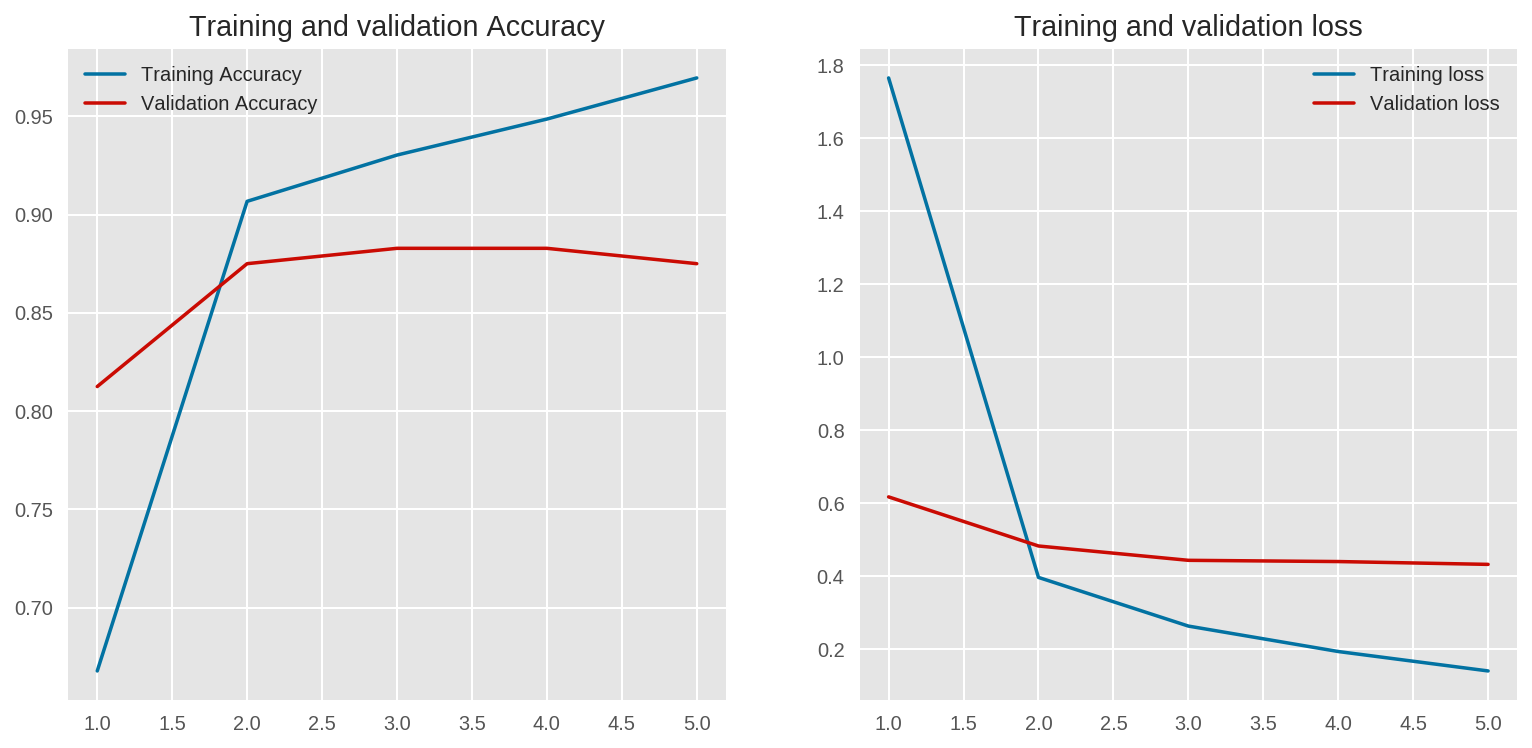

Test accuracy: 0.8921389579772949
cluster data with clusterId 8
size of data 4221
1267/1267 [==============================] - 0s 66us/step


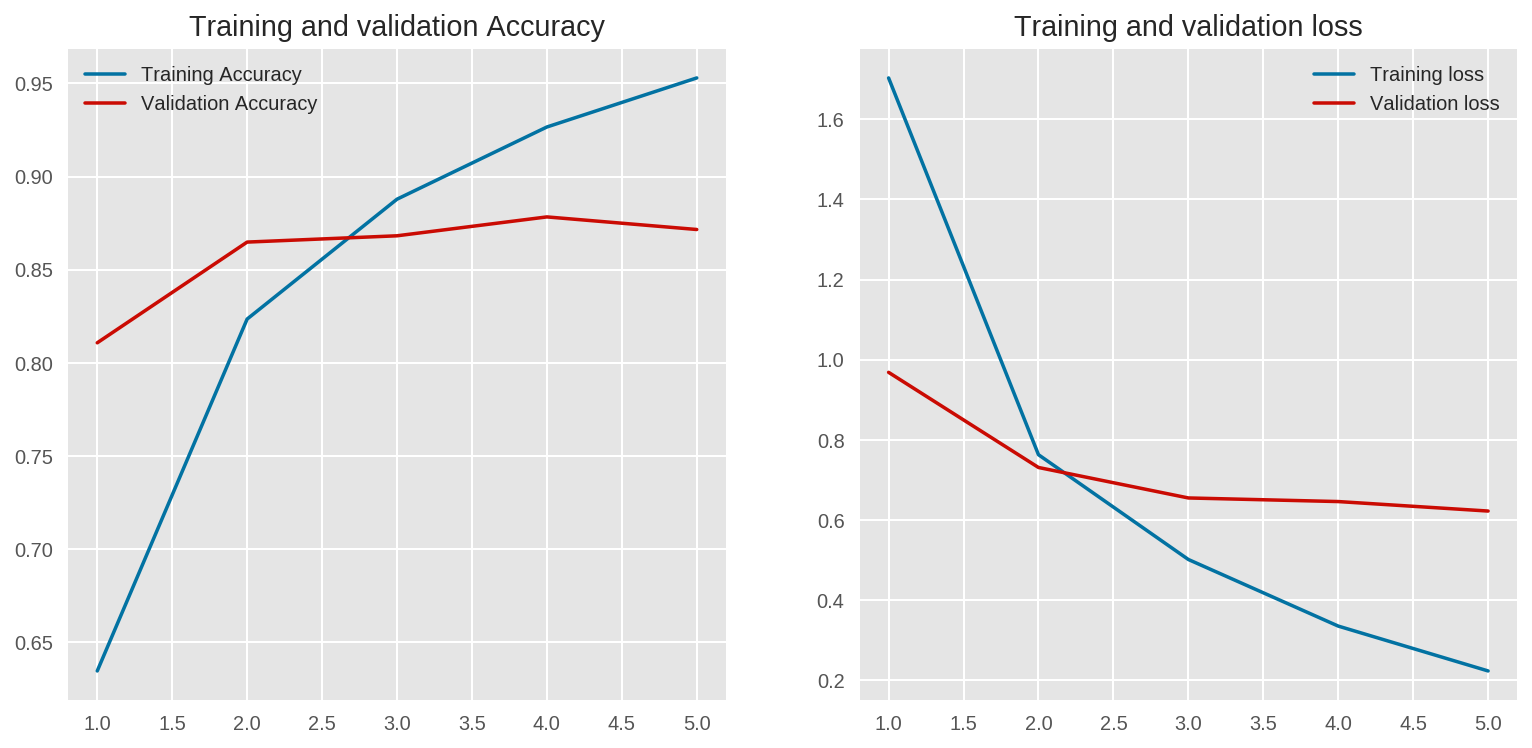

Test accuracy: 0.831886351108551
cluster data with clusterId 9
size of data 3325
998/998 [==============================] - 0s 67us/step


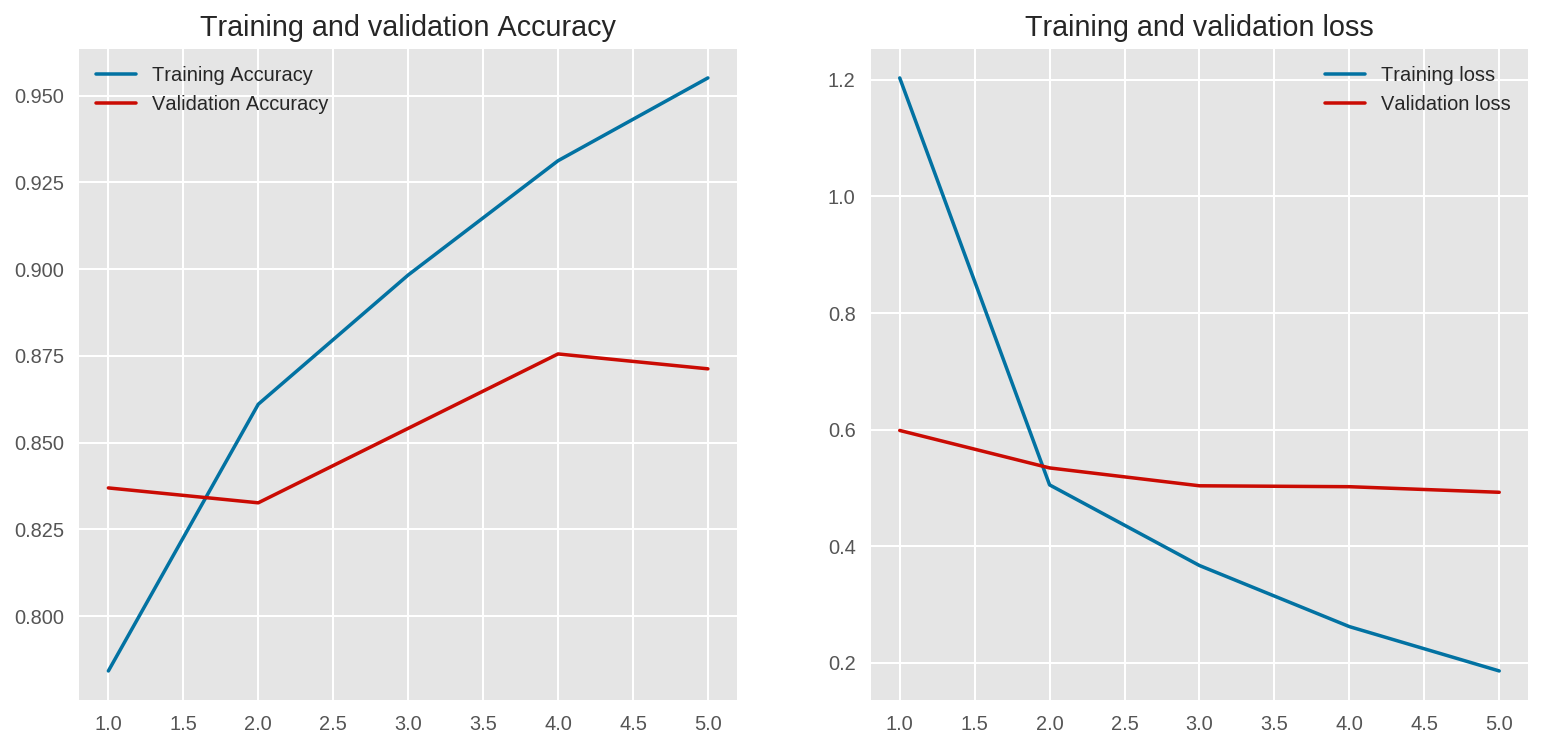

Test accuracy: 0.8647294640541077


In [17]:
from sklearn.model_selection import train_test_split

# Feature extraction and deep network for all clusters individually.
for i in cluster_id_list:
    print("cluster data with clusterId",i)
    
    # get cluster_data
    cluster_data=df_cluster[df_cluster['clusterId'].apply(lambda X: str(X) == str(i))]
    print("size of data",len(cluster_data))
    
    #convert into IF-IDF
    vectorizer = TfidfVectorizer(max_features=12000)
    words_tfIdf = vectorizer.fit_transform(cluster_data['text'])
    
    #find the number of targeted classes in cluster
    num_classes = max(cluster_data['lables']) + 1
    
    # convert targeted columns into binary matrix
    y=keras.utils.to_categorical(cluster_data['lables'],num_classes)
    
    #split the data into train and test 
    x_train, x_test, y_train, y_test =train_test_split(words_tfIdf,y,test_size=0.3)
    
    # get extracted features using autiencoder
    data_train,data_test=getExtractedFeature(x_train,x_test)
    
    #Perform deep nural network with extracted features.
    neuralNetworkFunction(data_train,data_test,y_train,y_test,num_classes)
    
  

### Approach 2:  Deep neural network with CNN: 

We've performed CNN deep neural network as second approach.
- In CNN we used Word2vec to represent features.
- We've used trained Word vector using 'glove.6B.300d.txt'.
- Create embedding matrix to give weightage to the words in CNN network.
- We've performed CNN on target cluster to compare its result with approach 1's result.
- It shows that CNN also performs well with the text data.

**Reference** : https://realpython.com/python-keras-text-classification/ ( To create embedding_matrix from Glove.)

In [18]:
from sklearn.model_selection import train_test_split
from keras.preprocessing.sequence import pad_sequences
from keras.preprocessing.text import Tokenizer

# Get cluster with highest data.
df_cluster4=df_cluster[df_cluster['clusterId'].apply(lambda X: str(X) == str(4))]

# total No of target value 
num_classes = max(df_cluster4['lables']) + 1

#convert target value to categorical
y=keras.utils.to_categorical(df_cluster4['lables'],num_classes)

#split data into train and test
train, test, y_train, y_test = train_test_split(df_cluster4['text'],y , test_size=0.25, random_state=1000)

tokenizer = Tokenizer(num_words=4000)
tokenizer.fit_on_texts(train)

X_train = tokenizer.texts_to_sequences(train)
X_test = tokenizer.texts_to_sequences(test)

vocab_size = len(tokenizer.word_index) + 1  

#maximum length of data=250 
maxlength = 250
X_train = pad_sequences(X_train, padding='post', maxlen=maxlength)
X_test = pad_sequences(X_test, padding='post', maxlen=maxlength)


In [19]:
import numpy as np

# took referece from given link 

def word_embedding_fun(file, index, dim):
    vocab_size = len(index) + 1  
    matrix = np.zeros((vocab_size, dim))

    with open(file) as f:
        for line_file in f:
            word, *vector = line_file.split()
            if word in index:
                idx = index[word] 
                matrix[idx] = np.array(
                    vector, dtype=np.float32)[:dim]

    return matrix

embedding_dim = 300
embedding_matrix = word_embedding_fun('glove.6B.300d.txt',tokenizer.word_index, embedding_dim)

- Embedding layer: It is used for neural networks on text data, which improves the accuracy of network using weightage of different words.
- Maxpooling: Subsampling Layers, which compress the data.
- Dense layers work as output layers with softmax activation.
- Last layer depth equals Num of classes in the target.
- As mentioned before softmax and categorical_crossentropy perform better with multiclass problem.

In [20]:
from keras.layers.embeddings import Embedding
from keras.layers import Input, Dense, Conv1D, MaxPooling1D, UpSampling1D, Embedding, GlobalMaxPooling1D
from keras.models import Model
from keras import backend as K
from keras.models import Sequential
from keras.layers import LSTM, Reshape,Permute, TimeDistributed, Bidirectional
from keras.layers import Dense, Activation, Flatten

embedding_dim = 300
model = Sequential()
model.add(Embedding(vocab_size, embedding_dim, input_length=maxlength))
model.add(Conv1D(256, 3, activation='tanh'))
model.add(GlobalMaxPooling1D())
model.add(Dense(512, activation='tanh'))
model.add(Dense(101, activation='softmax'))
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])
model.summary()

Model: "sequential_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 250, 300)          14178900  
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 248, 256)          230656    
_________________________________________________________________
global_max_pooling1d_1 (Glob (None, 256)               0         
_________________________________________________________________
dense_49 (Dense)             (None, 512)               131584    
_________________________________________________________________
dense_50 (Dense)             (None, 101)               51813     
Total params: 14,592,953
Trainable params: 14,592,953
Non-trainable params: 0
_________________________________________________________________


In [23]:
history = model.fit(X_train, y_train,
                    epochs=5,
                    verbose=False,
                    validation_data=(X_test, y_test),
                    batch_size=10)
loss_train, accuracy_train = model.evaluate(X_train, y_train, verbose=False)
loss_test, accuracy_test = model.evaluate(X_test, y_test, verbose=False)
print("Training Accuracy: {:.4f}".format(accuracy_train))
print("Testing Accuracy:  {:.4f}".format(accuracy_test))

Training Accuracy: 0.9812
Testing Accuracy:  0.6838


### <center>Conclusion</center>

**Modifications from Assignment 1 with supporting reasons**

- We have used clustering before classification which have reduced the number of class labels per cluster. Also reduced the features per cluster due to the varying document word sizes. This reduced the complexity of classification algorithm as it used to be in Assignment 1. This "cluster before classification" approach, improved classification performance for all the clusters thus leading to improved average classification accuracy (SVM and Rand. Forest) of whole corpus.

- We used all the raw features in Assignment 1, which added to the complexity of the model. Here, we have extracted the most important features using the Autoencoder which not only decreases the complexity, but lowers the dimentionality of feature space by removing uncorrelated (or superfluous) features. 

- Using DNN also helps to deal with high dimentional text data and finding underlying correlations in data.
Deep Learning is efficient to deal with large datasets and improve its predictive performance with increase in data.